# MC030 - Projeto final de Graduação
## Análise e Previsão do Mercado de Ações

## Descrição do modelo

A partir de um conjunto de cotações diárias de dólar para real (USD-BRL) desejamos modelar esse comportamento a partir de uma série de indicadores de mercado financeiro para classificarmos cada dia como um momento de compra ou momento de venda.

# ...

# Código

### Definindo endpoints da API (https://www.alphavantage.co/documentation/)

In [1]:
apiToken = '3GX5M109KQK9B6HO'
baseUrl = 'https://www.alphavantage.co/query?&outputsize=full&apikey=' + apiToken
usdBrlUrl = 'https://www.alphavantage.co/query?function=FX_DAILY&from_symbol=USD&to_symbol=BRL&outputsize=full&apikey=' + apiToken
stockUrl = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=MSFT&outputsize=full&apikey=demo'

### Obtendo dados da API

In [2]:
import requests
import json
import time

callsMade = 0

def incrementAndVerifyCallsMade():
    global callsMade
    callsMade += 1
    if callsMade == 5:
        print('Made 5 requests to the API in the last minute - sleeping for 1 minute')
        time.sleep(65)
        callsMade = 0

# returns [{date: {open, close, high, low, volume}}]
# all data is normalized/adjusted according to splits and dividends
def getStockPrice(stockSymbol):
    stockUrl = baseUrl + '&function=TIME_SERIES_DAILY_ADJUSTED&symbol=' + stockSymbol
    print('Fetching ' + stockUrl)
    incrementAndVerifyCallsMade()
    stocksRetrieved = requests.get(stockUrl).json();
    stocks = parseAndAdjustPrice(stocksRetrieved['Time Series (Daily)'])
    print('Retrieved and parsed '+ stockSymbol)
    return stocks

### Parseando dados da API

In [3]:
def parseAndAdjustPrice(stocksRetrieved):
    stockPrices = {}
    splitFactor = 1.0
    dividendsFactor = 1.0
    i = 0
    
    for date in reversed(sorted(stocksRetrieved.keys())):
        # Calculando valores ajustados
        todayOpen = float(stocksRetrieved[date]['1. open']) * dividendsFactor / splitFactor
        todayHigh = float(stocksRetrieved[date]['2. high']) * dividendsFactor / splitFactor
        todayLow = float(stocksRetrieved[date]['3. low']) * dividendsFactor / splitFactor
        todayClose = float(stocksRetrieved[date]['4. close']) * dividendsFactor / splitFactor
        todayVolume = float(stocksRetrieved[date]['6. volume']) * splitFactor
        
#         # Analisando possível erro -- nao funciona por razões de arredondamento (api deve ter dados com mais casas decimais)
#         if (int(todayClose*10000) != int(float(stocksRetrieved[date]['5. adjusted close'])*10000)):
#             print('Adjusted values dont match: (calculated) ' + str(int(todayClose*10000)) + ' vs ' + str(int(float(stocksRetrieved[date]['5. adjusted close'])*10000)) + ' (api)')
#             print('Aborting operation')
#             raise Exception('Adjusted values dont match')
        
        stockPrices[date] = {
            'open': todayOpen,
            'close': todayClose,
            'high': todayHigh,
            'low': todayLow,
            'volume': todayVolume,
        }

        # Calculando fatores históricos de split e dividendos (que irão afetar datas antes da atual)
        if (i+1 < len(stocksRetrieved.keys())):
            yesterdayDate = list(reversed(sorted(stocksRetrieved.keys())))[i+1]
            yesterdayClose = float(stocksRetrieved[yesterdayDate]['4. close'])
            splitFactor *= float(stocksRetrieved[date]['8. split coefficient'])
            dividendsFactor *= (yesterdayClose-float(stocksRetrieved[date]['7. dividend amount']))/yesterdayClose
            i += 1
        
    print('Preço final normalizado (calculado): ' + str(stockPrices[sorted(stockPrices.keys())[0]]['close'])
         + ' | ' + sorted(stockPrices.keys())[0])
    print('Preço final normalizado (api): ' + str(stocksRetrieved[sorted(stocksRetrieved.keys())[0]]['5. adjusted close'])
         + ' | ' + sorted(stocksRetrieved.keys())[0])
        
    return stockPrices

# returns [{date: price}]
def simplifyStockPrices(stockPrices):
    stockPricesSimplified = {}
    for date, stockData in stockPrices.items():
        stockPricesSimplified[date] = stockData['open']
    return stockPricesSimplified

### Obtendo indicadores

In [4]:
from talib.abstract import *
import numpy as np

# returns [date: [{indicatorFunction: indicatorValue}]]
def getIndicator(indicatorFunction, stockPrices):
    indicator = {}
    opens, highs, lows, closes, volumes = [], [], [], [], []
    
    for date in sorted(stockPrices.keys()):
        opens.append(stockPrices[date]['open'])
        highs.append(stockPrices[date]['high'])
        lows.append(stockPrices[date]['low'])
        closes.append(stockPrices[date]['close'])
        volumes.append(stockPrices[date]['volume'])
    
    inputs = {
        'open': np.array(opens),
        'high': np.array(highs),
        'low': np.array(lows),
        'close': np.array(closes),
        'volume': np.array(volumes)
    }
    
    if indicatorFunction=='SMA':
        indicatorList = SMA(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='EMA':
        indicatorList = EMA(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='WMA':
        indicatorList = EMA(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='MACD':
        indicatorList, macdsignal, macdhist = MACD(inputs, fastperiod=12, slowperiod=26, signalperiod=9)
    elif indicatorFunction=='RSI':
        indicatorList = RSI(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='ADX':
        indicatorList = ADX(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='CCI':
        indicatorList = CCI(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='MOM':
        indicatorList = MOM(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='WILLR':
        indicatorList = WILLR(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='AD':
        indicatorList = AD(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='ADOSC':
        indicatorList = ADOSC(inputs, timeperiod=10, price='open')
    elif indicatorFunction=='OBV':
        indicatorList = OBV(inputs, timeperiod=10, price='open')
    
    i = 0
    indicators = {}
    for date in sorted(stockPrices.keys()):
        indicators[date] = {indicatorFunction: indicatorList[i]}
        i += 1
        
    print('Calculated and parsed indicator ' + indicatorFunction)
    return indicators

# returns [date: [{indicatorFunction: indicatorValue}]]
def getIndicatorList(indicatorFunctions, stockPrices):
    indicators = {}
    for indicatorFunction in indicatorFunctions:
        indicatorDict = getIndicator(indicatorFunction, stockPrices)
        for date, indicator in indicatorDict.items():
            for indicatorFunction, indicatorValue in indicator.items():
                if  date not in indicators:
                    indicators[date] = {}
                indicators[date][indicatorFunction] = indicatorValue
    return indicators

In [5]:
# Filtrando dados válidos - apenas aqueles cujas datas estão na lista de preços e de indicadores
def filterData(stocks, indicators, indicatorFunctions):
    filteredStocks = {date: stock for date, stock in stocks.items() if date in indicators.keys()}
    filteredIndicators = {date: indicators for date, indicators in indicators.items() if date in stocks.keys()}
    return filteredStocks, filteredIndicators

def getData(stockSymbol, indicatorFunctions):
    stockPricesDetailed = getStockPrice(stockSymbol)
    indicators = getIndicatorList(indicatorFunctions, stockPricesDetailed)
    stockPrices, indicators = filterData(stockPricesDetailed, indicators, indicatorFunctions)
    return stockPricesDetailed, indicators

### Métodos de anotação de dados

In [6]:
import collections

def annotateBuyOrSellTwoClasses(prices):
    dateAnnotated = {}
    yesterdayDate = ''
    earlierDate = ''
    last = ''
    for key, value in prices.items():
        yesterdayDate = key
        yesterdayPrice = float(value)
        break
    for date, price in prices.items():
        if float(price) > yesterdayPrice:
            dateAnnotated[yesterdayDate] = 'B'
            last = 'B'
        elif float(price) < yesterdayPrice:
            dateAnnotated[yesterdayDate] = 'S'
            last = 'S'
        else:
            dateAnnotated[yesterdayDate] = last
        yesterdayDate = date
        yesterdayPrice = float(price)
    return dateAnnotated

def annotateBuyOrSellEightClasses(prices):
    dateAnnotated = {}
    yesterdayDate = ''
    earlierDate = ''
    last = ''
    for key, value in prices.items():
        yesterdayDate = key
        yesterdayPrice = float(value)
        break
    for date, price in prices.items():
        if float(price) > yesterdayPrice and float(price)/yesterdayPrice <= 1.005:
            dateAnnotated[yesterdayDate] = 'B0'
            last = 'B0'
        elif float(price) > yesterdayPrice and float(price)/yesterdayPrice <= 1.01:
            dateAnnotated[yesterdayDate] = 'B1'
            last = 'B1'
        elif float(price) > yesterdayPrice and float(price)/yesterdayPrice <= 1.02:
            dateAnnotated[yesterdayDate] = 'B2'
            last = 'B2'
        elif float(price) > yesterdayPrice and float(price)/yesterdayPrice > 1.02:
            dateAnnotated[yesterdayDate] = 'B3'
            last = 'B3'
        elif float(price) < yesterdayPrice and float(price)/yesterdayPrice >= .995:
            dateAnnotated[yesterdayDate] = 'S0'
            last = 'S0'
        elif float(price) < yesterdayPrice and float(price)/yesterdayPrice >= .99:
            dateAnnotated[yesterdayDate] = 'S1'
            last = 'S1'
        elif float(price) < yesterdayPrice and float(price)/yesterdayPrice >= .98:
            dateAnnotated[yesterdayDate] = 'S2'
            last = 'S2'
        elif float(price) < yesterdayPrice and float(price)/yesterdayPrice < .98:
            dateAnnotated[yesterdayDate] = 'S3'
            last = 'S3'
        else:
            dateAnnotated[yesterdayDate] = last
        yesterdayDate = date
        yesterdayPrice = float(price)
    return dateAnnotated

def annotateMaxProfit(prices):
    dateAnnotated = {}
    yesterdayDate = ''
    yesterdayPrice = 0
    currentStatus = ''
    for key, value in prices.items():
        yesterdayDate = key
        yesterdayPrice = value
        break
    for date, price in prices.items():
        if price > yesterdayPrice and currentStatus != 'B':
            dateAnnotated[yesterdayDate] = 'B'
            currentStatus = 'B'
        elif price < yesterdayPrice and currentStatus != 'S':
            dateAnnotated[yesterdayDate] = 'S'
            currentStatus = 'S'
        yesterdayDate = date
        yesterdayPrice = price
    return dateAnnotated

### Normalização dos dados

In [7]:
import copy

# Normaliza um conjunto de indicadores a partir do preço da ação
def normalizeIndicators(indicatorSet, stocks):
    normalizedIndicatorSet = {}
    for indicatorFunction, indicatorValue in indicatorSet.items():
        # Normalizando baseado no preço
        if (indicatorFunction == 'SMA' or indicatorFunction == 'EMA' or indicatorFunction == 'MACD' or
            indicatorFunction == 'RSI' or indicatorFunction == 'ADX' or indicatorFunction == 'CCI' or
            indicatorFunction == 'MOM' or indicatorFunction == 'WILLR'):
            normalizedIndicatorSet[indicatorFunction] = float(indicatorValue)/float(stocks['close'])
        # Normalizando baseado no volume
        elif (indicatorFunction == 'AD' or indicatorFunction == 'ADOSC' or indicatorFunction == 'OBV'):
            normalizedIndicatorSet[indicatorFunction] = float(indicatorValue)/float(stocks['volume'])
    return normalizedIndicatorSet

# Retorna os indicadores normalizados: indicadores = [date: {indicators: ['SMA': 0.89, 'EMA': 0.93], annotation: 'B'}]
def getIndicatorsNormalizedAndAnnotaded(stocks, indicators, dateAnnotated):
    print('Normalizing and annotating indicators')
    indicatorsAnnotated = {}
    for date, annotation in dateAnnotated.items():
        if date not in indicatorsAnnotated:
            indicatorsAnnotated[date] = {'indicators': {}, 'annotation': ''}
        indicatorsAnnotated[date]['indicators'] = normalizeIndicators(indicators[date], stocks[date])
        indicatorsAnnotated[date]['annotation'] = annotation
    return indicatorsAnnotated

### Machine Learning

In [8]:
import keras
adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

def getModelMLP(n_steps, n_features, n_outputs):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(n_steps*n_features*2, activation='relu', input_shape=(n_steps*n_features,)))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(n_steps*n_features*2, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    if (n_outputs > 1):
        activation = 'softmax'
        loss = 'categorical_crossentropy'
    else:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    model.add(keras.layers.Dense(n_outputs, activation=activation))
    model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
    return model

def getModelLSTM(n_steps, n_features, n_outputs):    
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(n_steps*n_features*2, activation='relu', input_shape=(n_steps, n_features)))
    if (n_outputs > 1):
        activation = 'softmax'
        loss = 'categorical_crossentropy'
    else:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    model.add(keras.layers.Dense(n_outputs, activation=activation))
    model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
    return model

def getModelBidirectionalLSTM(n_steps, n_features, n_outputs):    
    model = keras.models.Sequential()
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(n_steps*n_features*2, activation='relu'), input_shape=(n_steps, n_features)))
    if (n_outputs > 1):
        activation = 'softmax'
        loss = 'categorical_crossentropy'
    else:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    model.add(keras.layers.Dense(n_outputs, activation=activation))
    model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
    return model

def getModelCNN(n_steps, n_features):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
    model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(50, activation='relu'))
    if (n_outputs > 1):
        activation = 'softmax'
        loss = 'categorical_crossentropy'
    else:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    model.add(keras.layers.Dense(n_outputs, activation=activation))
    model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
    return model

Using TensorFlow backend.


### Análise de dados

In [9]:
import itertools
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    return cm

### Main

In [10]:
# Cheat-sheet com os simbolos
__indicatorSymbols = ['SMA', 'EMA', 'WMA', 'DEMA', 'TEMA', 'TRIMA', 'KAMA', 'MAMA',
                      'T3', 'MACD', 'MACDEXT', 'STOCH', 'STOCHF', 'RSI', 'STOCHRSI', 'WILLR', 
                      'ADX', 'ADXR', 'APO', 'PPO', 'MOM', 'BOP', 'CCI', 'CMO', 'ROC', 'ROCR',
                      'AROON', 'AROONOSC', 'MFI', 'TRIX', 'ULTOSC', 'DX', 'MINUS_DI', 'PLUS_DI',
                      'MINUS_DM', 'PLUS_DM', 'BBANDS', 'MIDPOINT', 'SAR', 'TRANGE', 'ATR',
                      'NATR', 'AD', 'ADOSC', 'OBV', 'HT_TRENDLINE', 'HT_SINE', 'HT_TRENDMODE',
                      'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR']
__forexSymbols = ['BRL', 'EUR']
__stockSymbols = ['MSFT']

# Definindo simbolos para o modelo
indicatorFunctions = {}
indicatorFunctions[3] = ['SMA', 'EMA', 'WMA']
indicatorFunctions[6] = ['SMA', 'EMA', 'MACD', 'RSI', 'ADX', 'CCI'] #'AD', 'OBV']
indicatorFunctions[8] = ['SMA', 'EMA', 'MACD', 'RSI', 'ADX', 'CCI', 'MOM', 'WILLR'] #'AD', 'OBV', 'ADOSC']
stockSymbol = 'MSFT'

stocks, indicators = getData(stockSymbol, indicatorFunctions[8])
stockPrices = simplifyStockPrices(stocks)
# forexPrices, indicators = getForexData(fromForexSymbol, toForexSymbol, indicatorFunctions)
# dateAnnotated = annotateMaxProfit(stockPrices)

Fetching https://www.alphavantage.co/query?&outputsize=full&apikey=3GX5M109KQK9B6HO&function=TIME_SERIES_DAILY_ADJUSTED&symbol=MSFT
Preço final normalizado (calculado): 29.311284084356068 | 1999-11-26
Preço final normalizado (api): 29.3751 | 1999-11-26
Retrieved and parsed MSFT
Calculated and parsed indicator SMA
Calculated and parsed indicator EMA
Calculated and parsed indicator MACD
Calculated and parsed indicator RSI
Calculated and parsed indicator ADX
Calculated and parsed indicator CCI
Calculated and parsed indicator MOM
Calculated and parsed indicator WILLR
{'1999-11-26': {'SMA': nan, 'EMA': nan, 'MACD': nan, 'RSI': nan, 'ADX': nan, 'CCI': nan, 'MOM': nan, 'WILLR': nan}, '1999-11-29': {'SMA': nan, 'EMA': nan, 'MACD': nan, 'RSI': nan, 'ADX': nan, 'CCI': nan, 'MOM': nan, 'WILLR': nan}, '1999-11-30': {'SMA': nan, 'EMA': nan, 'MACD': nan, 'RSI': nan, 'ADX': nan, 'CCI': nan, 'MOM': nan, 'WILLR': nan}, '1999-12-01': {'SMA': nan, 'EMA': nan, 'MACD': nan, 'RSI': nan, 'ADX': nan, 'CCI': n

In [11]:
import pandas as pd

df = pd.DataFrame.from_dict(stockPrices, orient='index')

In [12]:
df[0] = df[0].astype('float')

In [13]:
div = df[0].astype('float').div(df[0].astype('float').shift(-1))

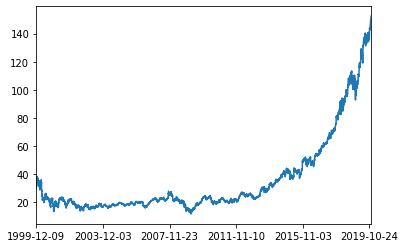

In [12]:
df.sort_index(inplace=True)
df[0].astype('float').plot()

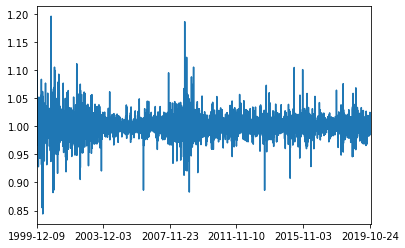

In [13]:
div.sort_index(inplace=True)
div.plot()

In [14]:
div.describe(percentiles=[.01,.1,.25,.5,.75,.9,.95,.99])

count    5024.000000
mean        1.000506
std         0.019073
min         0.843932
1%          0.945991
10%         0.981155
25%         0.991930
50%         1.000331
75%         1.008974
90%         1.019987
95%         1.028962
99%         1.056002
max         1.195749
Name: 0, dtype: float64

In [15]:
div

1999-12-09         NaN
1999-12-10    1.012077
1999-12-13    1.029294
1999-12-14    1.021423
1999-12-15    1.098795
                ...   
2019-11-21    0.999064
2019-11-22    1.000736
2019-11-25    1.010963
2019-11-26    1.005290
2019-11-27    1.001908
Name: 0, Length: 5025, dtype: float64

In [16]:
dateAnnotated = {}

dateAnnotated[2] = annotateBuyOrSellTwoClasses(stockPrices)
df = pd.DataFrame.from_dict(dateAnnotated[2], orient='index')
df[0].value_counts()

S    2579
B    2445
Name: 0, dtype: int64

In [17]:
dateAnnotated[8] = annotateBuyOrSellEightClasses(stockPrices)
df = pd.DataFrame.from_dict(dateAnnotated[8], orient='index')
df[0].value_counts()

S0    806
B0    790
S2    663
S1    624
B1    608
B2    571
S3    486
B3    476
Name: 0, dtype: int64

In [18]:
import pandas as pd

normalizedIndicators = {}
normalizedIndicators[2] = getIndicatorsNormalizedAndAnnotaded(stocks, indicators, dateAnnotated[2])
normalizedIndicators[8] = getIndicatorsNormalizedAndAnnotaded(stocks, indicators, dateAnnotated[8])

data = {}
data[2] = pd.DataFrame.from_dict(normalizedIndicators[2], orient='index')
data[8] = pd.DataFrame.from_dict(normalizedIndicators[8], orient='index')

Normalizing and annotating indicators
Normalizing and annotating indicators


In [20]:
data[2] = pd.DataFrame.merge(pd.DataFrame(data[2].indicators.values.tolist(), index=data[2].index), data[2], left_index=True, right_index=True, how='outer').drop(columns=['indicators'])
data[8] = pd.DataFrame.merge(pd.DataFrame(data[8].indicators.values.tolist(), index=data[8].index), data[8], left_index=True, right_index=True, how='outer').drop(columns=['indicators'])

In [21]:
data[2].head(), data[8].head()

(                 SMA       EMA      MACD       RSI       ADX       CCI  \
 2019-11-27  0.984947  0.983548  0.017402  0.512410  0.311394  0.866663   
 2019-11-26  0.987566  0.986171  0.016928  0.497518  0.306620  1.029319   
 2019-11-25  0.993133  0.992012  0.016737  0.471092  0.302143  0.689063   
 2019-11-22  0.989565  0.989775  0.016968  0.475007  0.298581  0.313525   
 2019-11-21  0.989926  0.991931  0.017056  0.461408  0.301483  0.302567   
 
                  MOM     WILLR annotation  
 2019-11-27  0.036697 -0.021484          S  
 2019-11-26  0.033562 -0.041965          S  
 2019-11-25  0.031067 -0.015123          B  
 2019-11-22  0.040581 -0.175675          S  
 2019-11-21  0.037216 -0.163578          B  ,
                  SMA       EMA      MACD       RSI       ADX       CCI  \
 2019-11-27  0.984947  0.983548  0.017402  0.512410  0.311394  0.866663   
 2019-11-26  0.987566  0.986171  0.016928  0.497518  0.306620  1.029319   
 2019-11-25  0.993133  0.992012  0.016737  0.471092 

In [22]:
data[2].annotation = data[2].annotation.apply(lambda x: 0 if x == 'S' else 1)

eight_dict = {"B3":0, "B2": 1, "B1": 2, "B0": 3, "S0": 4, "S1": 5, "S2": 6, "S3": 7}
data[8].annotation = data[8].annotation.apply(lambda x: eight_dict[x])

In [23]:
data[2] = data[2].sort_index()
data[8] = data[8].sort_index()

In [24]:
data[2] = data[2].dropna()
data[8] = data[8].dropna()

In [25]:
len(data[2]), len(data[8])

(5001, 5001)

In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns

data_analysis = pd.DataFrame.merge(data[2], div, left_index=True, right_index=True, how='inner')
X = data_analysis.iloc[:,:8]
y = data_analysis.iloc[:,-1:]

In [27]:
bestfeatures = SelectKBest(score_func=f_classif, k=8)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
print(featureScores.nlargest(8,'Score'))

/Users/rodrigohilkner/opt/anaconda3/envs/pfg/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


   Specs     Score
0    SMA  3.349017
1    EMA  3.232283
6    MOM  2.173882
3    RSI  1.454493
2   MACD  1.077520
4    ADX  1.009415
7  WILLR  0.935693
5    CCI  0.913109


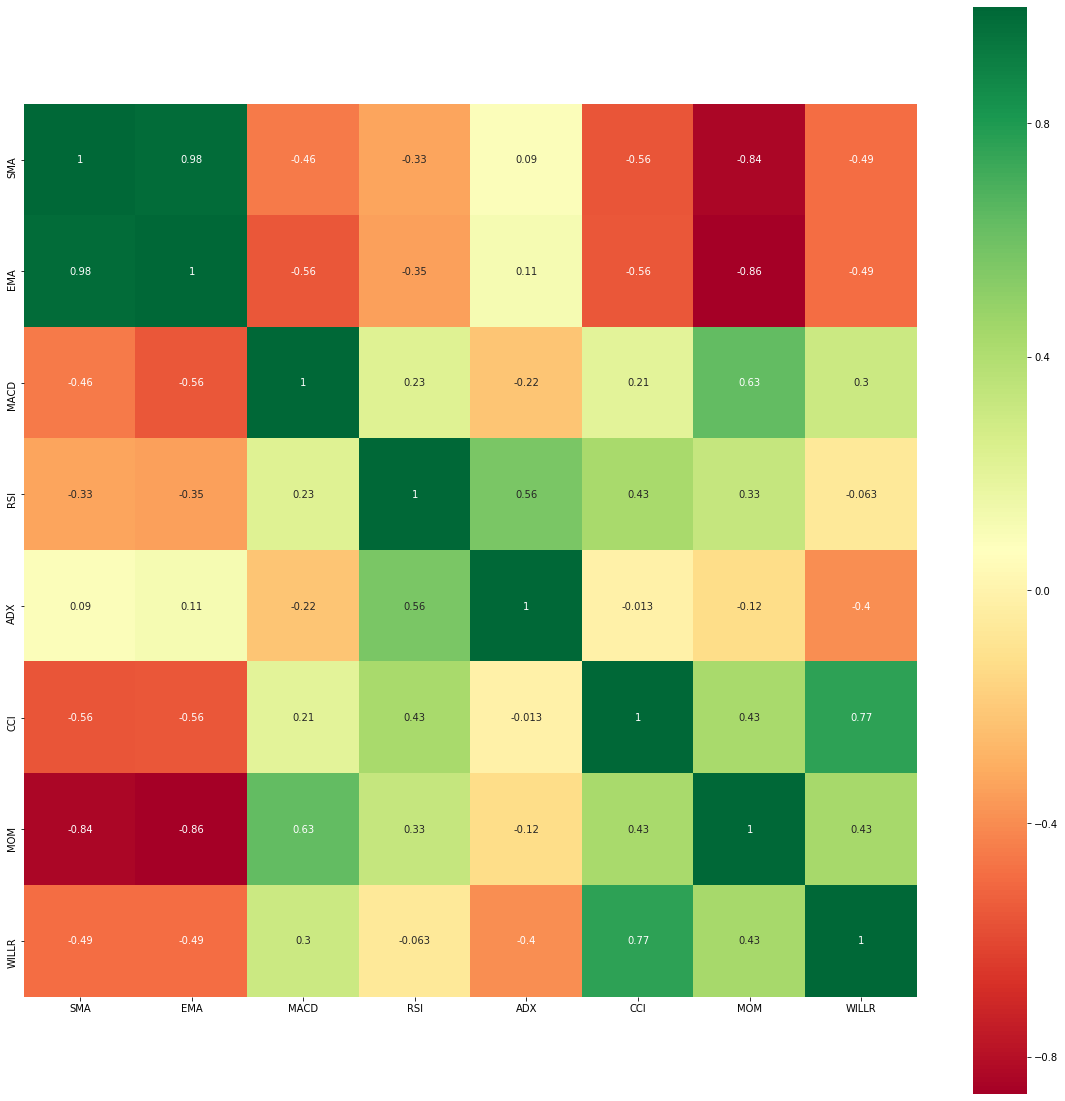

In [28]:
corrmat = data_analysis.iloc[:,:8].corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
plt.axis('scaled')
g=sns.heatmap(data_analysis[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [35]:
import numpy as np
import matplotlib.pyplot as plt

models = ["mlp","lstm"]
classes = {2: ["S","B"],
           8: ["B3","B2","B1","B0","S0","S1","S2","S3"]}
n_classes = [2, 8]
n_steps = [2,5,10]
n_indicators = [3, 6]
n_indicators_names = {
    3: ['SMA','MOM','WILLR'], 
    6: ['SMA','MOM','WILLR', 'MACD','ADX','RSI']
}

batch_size = 32
train_split = .8

# X [d: (all, train, test)] [m: type(mlp/lstm)] [c: classes(2, 8)] [s: n_steps(2,5,10)] [i: indicators(3, 6)] 

In [36]:
X = {}
y = {}
for a in ["all", "train", "test"]:
    X[a] = {}
    y[a] = {}
    for m in models:
        X[a][m] = {}
        y[a][m] = {}
        for c in n_classes:
            X[a][m][c] = {}
            y[a][m][c] = {}
            for s in n_steps:
                X[a][m][c][s] = {}
                y[a][m][c][s] = {}
                for i in n_indicators:
                    X[a][m][c][s][i] = []
                    y[a][m][c][s][i] = []
                    if a == "all":
                        for d in range(len(data[c])):
                            end_ix = d + s
                            print('Executing loop for ' + str(end_ix))
                            if end_ix > len(data[c]):
                                break
                            seq_x, seq_y = data[c].loc[data[c].index.isin(data[c].index[d:end_ix]), n_indicators_names[i]].values, data[c].iloc[end_ix-1, -1]
                            if m == "lstm":
                                X[a][m][c][s][i].append(seq_x)
                            else:
                                X[a][m][c][s][i].append(seq_x.flatten())
                            if c == 2:
                                y[a][m][c][s][i].append(seq_y)
                            else:
                                y[a][m][c][s][i].append(np.eye(c)[seq_y])
                        X[a][m][c][s][i] = np.array(X[a][m][c][s][i])
                        y[a][m][c][s][i] = np.array(y[a][m][c][s][i])

In [37]:
a = 'all'
for m in models:
    for c in n_classes:
        for s in n_steps:
            for i in n_indicators:
                print(X[a][m][c][s][i].shape, y[a][m][c][s][i].shape)

(5000, 6) (5000,)
(5000, 12) (5000,)
(5000, 16) (5000,)
(4997, 15) (4997,)
(4997, 30) (4997,)
(4997, 40) (4997,)
(4992, 30) (4992,)
(4992, 60) (4992,)
(4992, 80) (4992,)
(5000, 6) (5000, 8)
(5000, 12) (5000, 8)
(5000, 16) (5000, 8)
(4997, 15) (4997, 8)
(4997, 30) (4997, 8)
(4997, 40) (4997, 8)
(4992, 30) (4992, 8)
(4992, 60) (4992, 8)
(4992, 80) (4992, 8)
(5000, 2, 3) (5000,)
(5000, 2, 6) (5000,)
(5000, 2, 8) (5000,)
(4997, 5, 3) (4997,)
(4997, 5, 6) (4997,)
(4997, 5, 8) (4997,)
(4992, 10, 3) (4992,)
(4992, 10, 6) (4992,)
(4992, 10, 8) (4992,)
(5000, 2, 3) (5000, 8)
(5000, 2, 6) (5000, 8)
(5000, 2, 8) (5000, 8)
(4997, 5, 3) (4997, 8)
(4997, 5, 6) (4997, 8)
(4997, 5, 8) (4997, 8)
(4992, 10, 3) (4992, 8)
(4992, 10, 6) (4992, 8)
(4992, 10, 8) (4992, 8)


In [38]:
data[2].head()

SMA       EMA      MACD       RSI       ADX       CCI  \
2000-01-13  1.071352  1.059142  0.043820  0.362969  0.322410 -1.290558   
2000-01-14  1.033548  1.025591  0.036445  0.416666  0.294222 -0.102762   
2000-01-18  0.985869  0.986266  0.033163  0.481478  0.254412  1.024068   
2000-01-19  0.994787  0.998329  0.030821  0.463009  0.251036 -0.621482   
2000-01-20  1.022959  1.024879  0.026674  0.417443  0.253548 -0.705605   

                 MOM     WILLR  annotation  
2000-01-13 -0.129348 -0.604987           1  
2000-01-14 -0.096184 -0.347121           0  
2000-01-18 -0.049727 -0.103637           0  
2000-01-19 -0.027692 -0.573152           1  
2000-01-20 -0.037923 -0.653839           1

In [39]:
X["all"]["lstm"][2][5][6][0]

KeyError: 8

In [27]:
X["all"]["mlp"][2][2][6][0]

array([ 1.01144678,  0.99551209,  0.05188561,  0.49985543,  0.29725048,
       -0.51993688, -0.04407694, -0.53659444,  1.02252466,  1.0104852 ,
        0.04818475,  0.46577668,  0.28721525, -0.77021076, -0.06502242,
       -0.750287  ])

In [28]:
from sklearn.model_selection import train_test_split

for m in models:
    for c in n_classes:
        for s in n_steps:
            for i in n_indicators:
                if m == "mlp":
                    X['train'][m][c][s][i], X['test'][m][c][s][i], y['train'][m][c][s][i], y['test'][m][c][s][i] = train_test_split(X['all'][m][c][s][i], y['all'][m][c][s][i], train_size=train_split, random_state=0)
                else:
                    X['train'][m][c][s][i] = X['all'][m][c][s][i][:int(len(X['all'][m][c][s][i])*train_split)]
                    X['test'][m][c][s][i] = X['all'][m][c][s][i][int(len(X['all'][m][c][s][i])*train_split):]
                    y['train'][m][c][s][i] = y['all'][m][c][s][i][:int(len(y['all'][m][c][s][i])*train_split)]
                    y['test'][m][c][s][i] = y['all'][m][c][s][i][int(len(y['all'][m][c][s][i])*train_split):]

In [29]:
for a in ['train','test']:
    for m in models:
        for c in n_classes:
            for s in n_steps:
                for i in n_indicators:
                    print(X[a][m][c][s][i].shape, y[a][m][c][s][i].shape)

(3999, 6) (3999,)
(3999, 12) (3999,)
(3999, 16) (3999,)
(3996, 15) (3996,)
(3996, 30) (3996,)
(3996, 40) (3996,)
(3992, 30) (3992,)
(3992, 60) (3992,)
(3992, 80) (3992,)
(3999, 6) (3999, 8)
(3999, 12) (3999, 8)
(3999, 16) (3999, 8)
(3996, 15) (3996, 8)
(3996, 30) (3996, 8)
(3996, 40) (3996, 8)
(3992, 30) (3992, 8)
(3992, 60) (3992, 8)
(3992, 80) (3992, 8)
(3999, 2, 3) (3999,)
(3999, 2, 6) (3999,)
(3999, 2, 8) (3999,)
(3996, 5, 3) (3996,)
(3996, 5, 6) (3996,)
(3996, 5, 8) (3996,)
(3992, 10, 3) (3992,)
(3992, 10, 6) (3992,)
(3992, 10, 8) (3992,)
(3999, 2, 3) (3999, 8)
(3999, 2, 6) (3999, 8)
(3999, 2, 8) (3999, 8)
(3996, 5, 3) (3996, 8)
(3996, 5, 6) (3996, 8)
(3996, 5, 8) (3996, 8)
(3992, 10, 3) (3992, 8)
(3992, 10, 6) (3992, 8)
(3992, 10, 8) (3992, 8)
(1000, 6) (1000,)
(1000, 12) (1000,)
(1000, 15) (1000,)
(1000, 30) (1000,)
(999, 30) (999,)
(999, 60) (999,)
(1000, 6) (1000, 8)
(1000, 12) (1000, 8)
(1000, 15) (1000, 8)
(1000, 30) (1000, 8)
(999, 30) (999, 8)
(999, 60) (999, 8)
(1000, 2, 

In [30]:
Models = {}
for m in models:
    Models[m] = {}
    for c in n_classes:
        Models[m][c] = {}
        for s in n_steps:
            Models[m][c][s] = {}
            for i in n_indicators:
                Models[m][c][s][i] = {}
                if c == 2:
                    out = 1
                else:
                    out = c
                if m == "mlp":
                    Models[m][c][s][i] = getModelMLP(s, i, out)
                else:
                    Models[m][c][s][i] = getModelBidirectionalLSTM(s, i, out)

In [31]:
for m in models:
    for c in n_classes:
        for s in n_steps:
            for i in n_indicators:
                print(Models[m][c][s][i])

In [32]:
history = {}
preds = {}
conf = {}
for m in models:
    history[m] = {}
    preds[m] = {}
    conf[m] = {}
    for c in n_classes:
        history[m][c] = {}
        preds[m][c] = {}
        conf[m][c] = {}
        for s in n_steps:
            history[m][c][s] = {}
            preds[m][c][s] = {}
            conf[m][c][s] = {}
            for i in n_indicators:
                history[m][c][s][i] = {}
                preds[m][c][s][i] = {}
                conf[m][c][s][i] = {}

In [ ]:
# Calculando lucro/prejuízo total, supondo que inicialmente temos US$1000 em carteira
import copy

def calculateProfit(preds, stockPrices):
    classificationArray = list(np.argmax(preds["lstm"][8], axis=1))

    prices = copy.deepcopy(stockPrices)

    for date in sorted(stockPrices.keys()):
        if len(prices) == len(classificationArray):
            break
        del prices[date]

    initialMoney = 1000.00
    index = 0
    currentMoney = initialMoney
    currentStocks = 0.0

    for date in sorted(prices.keys()):
        stockPrice = float(prices[date])
        classification = classificationArray[index]
        # Caso de compra
        if currentMoney != 0 and (classification == 0 or classification == 1 or classification == 2 or classification == 3):
            currentStocks = currentMoney/stockPrice
            currentMoney = 0.0
        elif currentStocks != 0 and (classification == 4 or classification == 5 or classification == 6 or classification == 7):
            currentMoney = currentStocks*stockPrice
            currentStocks = 0.0
        index += 1

    firstPrice = float(prices[sorted(prices.keys())[0]])
    lastPrice = float(prices[sorted(prices.keys())[-1]])

    if currentMoney == 0:
        finalMoney = currentStocks*lastPrice

    growthPercentage = 100.0*((finalMoney-initialMoney)/initialMoney)
    timeLenInYears = len(prices)/252.0

    print("[DEBUG] Current money:\t   US$ " + str(round(currentMoney, 2)))
    print("[DEBUG] Current stocks:\t   " + str(round(currentStocks, 2)) + "\t| Last stock-price: US$ " + str(round(lastPrice, 2)))
    print("First date:\t   " + sorted(prices.keys())[1] + "\t| Initial stock value: US$ " + firstPrice)
    print("Last date:\t   " + sorted(prices.keys())[-1] + "\t| Final stock value: US$ " + lastPrice)
    print("Initial money:    US$ " + str(round(initialMoney, 2)) + " | Final money: US$ " + str(round(finalMoney, 2)))
    print("Final profit:\t   US$ " + str(round(finalMoney-initialMoney, 2)) + " over " + str(round(timeLenInYears, 2)) + " years")
    print("Growth percentage: " + str(round(growthPercentage, 2)) + "%")
    print("Growth per year:   US$ " + str(round((finalMoney-initialMoney)/timeLenInYears, 2)))

In [33]:
def fit(m, c, s, i):
    history[m][c][s][i] = Models[m][c][s][i].fit(
        X['train'][m][c][s][i], 
        y['train'][m][c][s][i], 
        epochs=300, 
        verbose=1,
        batch_size=batch_size)
    plt.plot(history[m][c][s][i].history['loss'], label='train')
#     plt.plot(history[m][c][s][i].history['val_loss'], label='test')
    plt.legend()
    plt.show()
    
def predict(m, c, s, i):
    preds[m][c][s][i] = Models[m][c][s][i].predict(
        X['test'][m][c][s][i], 
        batch_size=batch_size)
    print(f"Model {m}\nNumber of classes {c}\nNumber of steps {s}\nNumber of indicators {i}")
    print(classification_report(y['test'][m][c][s][i], 
                                np.rint(preds[m][c][s][i]).astype(np.int64), 
                                target_names=classes[c], 
                                digits=5))
    if c == 2:
        conf[m][c][s][i] = plot_confusion_matrix(y['test'][m][c][s][i], 
                                                 np.rint(preds[m][c][s][i]).astype(np.int64), 
                                                 classes=np.array(classes[c]))
    else:
        conf[m][c][s][i] = plot_confusion_matrix(y['test'][m][c][s][i].argmax(axis=1), 
                                                 np.rint(preds[m][c][s][i]).argmax(axis=1), 
                                                 classes=np.array(classes[c]))
        
def get_next_value(m, c, s, i):
    i = n_indicators[(n_indicators.index(i) + 1)%len(n_indicators)]
    if (n_indicators.index(i) == 0):
        s = n_steps[(n_steps.index(s) + 1)%len(n_steps)]
        if (n_steps.index(s) == 0):
            c = n_classes[(n_classes.index(c) + 1)%len(n_classes)]
            if (n_classes.index(c) == 0):
                m = models[(models.index(m) + 1)%len(models)]    
    return m, c, s, i

In [34]:
m = models[0]
c = n_classes[0]
s = n_steps[0]
i = n_indicators[0]

for x in range(36):
    Models[m][c][s][i].summary()
    m, c, s, i = get_next_value(m, c, s, i)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                448       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 O

Epoch 1/300
3999/3999 [==============================] - 0s 108us/step - loss: 0.6963 - accuracy: 0.5096
Epoch 2/300
3999/3999 [==============================] - 0s 43us/step - loss: 0.6934 - accuracy: 0.5076
Epoch 3/300
3999/3999 [==============================] - 0s 38us/step - loss: 0.6906 - accuracy: 0.5339
Epoch 4/300
3999/3999 [==============================] - 0s 37us/step - loss: 0.6885 - accuracy: 0.5396
Epoch 5/300
3999/3999 [==============================] - 0s 40us/step - loss: 0.6865 - accuracy: 0.5506
Epoch 6/300
3999/3999 [==============================] - 0s 38us/step - loss: 0.6842 - accuracy: 0.5581
Epoch 7/300
3999/3999 [==============================] - 0s 36us/step - loss: 0.6783 - accuracy: 0.5696
Epoch 8/300
3999/3999 [==============================] - 0s 37us/step - loss: 0.6683 - accuracy: 0.6004
Epoch 9/300
3999/3999 [==============================] - 0s 36us/step - loss: 0.6615 - accuracy: 0.6082
Epoch 10/300
3999/3999 [==============================] - 0s 37

3999/3999 [==============================] - 0s 35us/step - loss: 0.2440 - accuracy: 0.8960
Epoch 80/300
3999/3999 [==============================] - 0s 38us/step - loss: 0.2777 - accuracy: 0.8820
Epoch 81/300
3999/3999 [==============================] - 0s 34us/step - loss: 0.2585 - accuracy: 0.8877
Epoch 82/300
3999/3999 [==============================] - 0s 35us/step - loss: 0.2927 - accuracy: 0.8680
Epoch 83/300
3999/3999 [==============================] - 0s 35us/step - loss: 0.2794 - accuracy: 0.8742
Epoch 84/300
3999/3999 [==============================] - 0s 35us/step - loss: 0.2391 - accuracy: 0.9005
Epoch 85/300
3999/3999 [==============================] - 0s 40us/step - loss: 0.2101 - accuracy: 0.9120
Epoch 86/300
3999/3999 [==============================] - 0s 40us/step - loss: 0.2352 - accuracy: 0.8997
Epoch 87/300
3999/3999 [==============================] - 0s 38us/step - loss: 0.2778 - accuracy: 0.8830
Epoch 88/300
3999/3999 [==============================] - 0s 35us/st

3999/3999 [==============================] - 0s 35us/step - loss: 0.2383 - accuracy: 0.8987
Epoch 234/300
3999/3999 [==============================] - 0s 34us/step - loss: 0.2857 - accuracy: 0.8870
Epoch 235/300
3999/3999 [==============================] - 0s 35us/step - loss: 0.2852 - accuracy: 0.8812
Epoch 236/300
3999/3999 [==============================] - 0s 35us/step - loss: 0.2550 - accuracy: 0.8917
Epoch 237/300
3999/3999 [==============================] - 0s 34us/step - loss: 0.2367 - accuracy: 0.9042
Epoch 238/300
3999/3999 [==============================] - 0s 35us/step - loss: 0.2613 - accuracy: 0.8775
Epoch 239/300
3999/3999 [==============================] - 0s 35us/step - loss: 0.2107 - accuracy: 0.9170
Epoch 240/300
3999/3999 [==============================] - 0s 35us/step - loss: 0.2516 - accuracy: 0.8937
Epoch 241/300
3999/3999 [==============================] - 0s 35us/step - loss: 0.2395 - accuracy: 0.8965
Epoch 242/300
3999/3999 [==============================] - 0

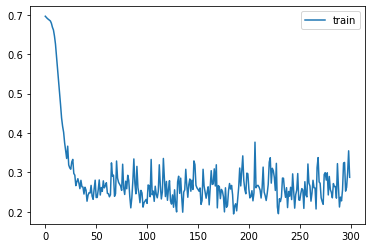

In [35]:
m = models[0]
c = n_classes[0]
s = n_steps[0]
i = n_indicators[0]

fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 2
Number of indicators 3
              precision    recall  f1-score   support

           S    0.94707   0.99208   0.96905       505
           B    0.99151   0.94343   0.96687       495

    accuracy                        0.96800      1000
   macro avg    0.96929   0.96776   0.96796      1000
weighted avg    0.96907   0.96800   0.96797      1000

Confusion matrix, without normalization
[[501   4]
 [ 28 467]]


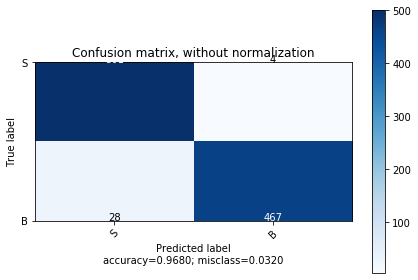

In [36]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 0s 93us/step - loss: 0.6096 - accuracy: 0.6862
Epoch 2/300
3999/3999 [==============================] - 0s 39us/step - loss: 0.5718 - accuracy: 0.7072
Epoch 3/300
3999/3999 [==============================] - 0s 40us/step - loss: 0.5503 - accuracy: 0.7337
Epoch 4/300
3999/3999 [==============================] - 0s 39us/step - loss: 0.5311 - accuracy: 0.7447
Epoch 5/300
3999/3999 [==============================] - 0s 41us/step - loss: 0.4895 - accuracy: 0.7759
Epoch 6/300
3999/3999 [==============================] - 0s 41us/step - loss: 0.4457 - accuracy: 0.7984
Epoch 7/300
3999/3999 [==============================] - 0s 39us/step - loss: 0.3839 - accuracy: 0.8325
Epoch 8/300
3999/3999 [==============================] - 0s 40us/step - loss: 0.3252 - accuracy: 0.8660
Epoch 9/300
3999/3999 [==============================] - 0s 40us/step - loss: 0.2748 - accuracy: 0.8877
Epoch 10/300
3999/3999 [==============================] - 0s 36u

3999/3999 [==============================] - 0s 35us/step - loss: 0.0969 - accuracy: 0.9625
Epoch 80/300
3999/3999 [==============================] - 0s 35us/step - loss: 0.0784 - accuracy: 0.9670
Epoch 81/300
3999/3999 [==============================] - 0s 35us/step - loss: 0.0938 - accuracy: 0.9630
Epoch 82/300
3999/3999 [==============================] - 0s 36us/step - loss: 0.1018 - accuracy: 0.9572
Epoch 83/300
3999/3999 [==============================] - 0s 35us/step - loss: 0.0802 - accuracy: 0.9670
Epoch 84/300
3999/3999 [==============================] - 0s 36us/step - loss: 0.0900 - accuracy: 0.9632
Epoch 85/300
3999/3999 [==============================] - 0s 36us/step - loss: 0.0863 - accuracy: 0.9627
Epoch 86/300
3999/3999 [==============================] - 0s 35us/step - loss: 0.0941 - accuracy: 0.9607
Epoch 87/300
3999/3999 [==============================] - 0s 36us/step - loss: 0.1005 - accuracy: 0.9575
Epoch 88/300
3999/3999 [==============================] - 0s 35us/st

3999/3999 [==============================] - 0s 39us/step - loss: 0.0613 - accuracy: 0.9785
Epoch 234/300
3999/3999 [==============================] - 0s 39us/step - loss: 0.0708 - accuracy: 0.9702
Epoch 235/300
3999/3999 [==============================] - 0s 40us/step - loss: 0.1067 - accuracy: 0.9575
Epoch 236/300
3999/3999 [==============================] - 0s 39us/step - loss: 0.0708 - accuracy: 0.9695
Epoch 237/300
3999/3999 [==============================] - 0s 40us/step - loss: 0.0868 - accuracy: 0.9660
Epoch 238/300
3999/3999 [==============================] - 0s 39us/step - loss: 0.0744 - accuracy: 0.9677
Epoch 239/300
3999/3999 [==============================] - 0s 39us/step - loss: 0.0918 - accuracy: 0.9622
Epoch 240/300
3999/3999 [==============================] - 0s 39us/step - loss: 0.0679 - accuracy: 0.9710
Epoch 241/300
3999/3999 [==============================] - 0s 41us/step - loss: 0.0733 - accuracy: 0.9685
Epoch 242/300
3999/3999 [==============================] - 0

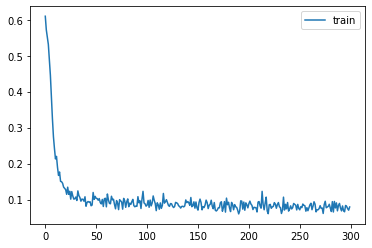

In [37]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 2
Number of indicators 6
              precision    recall  f1-score   support

           S    0.97670   0.99604   0.98627       505
           B    0.99588   0.97576   0.98571       495

    accuracy                        0.98600      1000
   macro avg    0.98629   0.98590   0.98599      1000
weighted avg    0.98619   0.98600   0.98600      1000

Confusion matrix, without normalization
[[503   2]
 [ 12 483]]


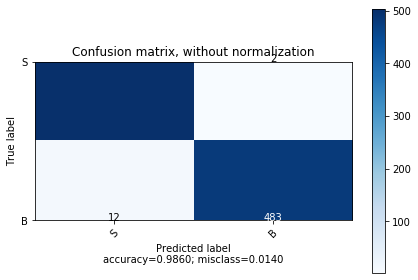

In [38]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 0s 104us/step - loss: 0.5978 - accuracy: 0.6957
Epoch 2/300
3999/3999 [==============================] - 0s 43us/step - loss: 0.5317 - accuracy: 0.7399
Epoch 3/300
3999/3999 [==============================] - 0s 46us/step - loss: 0.4913 - accuracy: 0.7627
Epoch 4/300
3999/3999 [==============================] - 0s 71us/step - loss: 0.4570 - accuracy: 0.7957
Epoch 5/300
3999/3999 [==============================] - 0s 40us/step - loss: 0.4426 - accuracy: 0.8045
Epoch 6/300
3999/3999 [==============================] - 0s 60us/step - loss: 0.4085 - accuracy: 0.8127
Epoch 7/300
3999/3999 [==============================] - 0s 49us/step - loss: 0.3958 - accuracy: 0.8212
Epoch 8/300
3999/3999 [==============================] - 0s 45us/step - loss: 0.3814 - accuracy: 0.8320
Epoch 9/300
3999/3999 [==============================] - 0s 42us/step - loss: 0.3550 - accuracy: 0.8455
Epoch 10/300
3999/3999 [==============================] - 0s 52

3999/3999 [==============================] - 0s 38us/step - loss: 0.1103 - accuracy: 0.9590
Epoch 80/300
3999/3999 [==============================] - 0s 38us/step - loss: 0.1032 - accuracy: 0.9560
Epoch 81/300
3999/3999 [==============================] - 0s 36us/step - loss: 0.1103 - accuracy: 0.9572
Epoch 82/300
3999/3999 [==============================] - 0s 35us/step - loss: 0.1049 - accuracy: 0.9545
Epoch 83/300
3999/3999 [==============================] - 0s 39us/step - loss: 0.0949 - accuracy: 0.9617
Epoch 84/300
3999/3999 [==============================] - 0s 38us/step - loss: 0.0978 - accuracy: 0.9602
Epoch 85/300
3999/3999 [==============================] - 0s 44us/step - loss: 0.0935 - accuracy: 0.9625
Epoch 86/300
3999/3999 [==============================] - 0s 47us/step - loss: 0.1196 - accuracy: 0.9497
Epoch 87/300
3999/3999 [==============================] - 0s 46us/step - loss: 0.1013 - accuracy: 0.9547
Epoch 88/300
3999/3999 [==============================] - 0s 45us/st

3999/3999 [==============================] - 0s 40us/step - loss: 0.0753 - accuracy: 0.9690
Epoch 234/300
3999/3999 [==============================] - 0s 47us/step - loss: 0.0946 - accuracy: 0.9577
Epoch 235/300
3999/3999 [==============================] - 0s 42us/step - loss: 0.0890 - accuracy: 0.9630
Epoch 236/300
3999/3999 [==============================] - 0s 40us/step - loss: 0.0957 - accuracy: 0.9585
Epoch 237/300
3999/3999 [==============================] - 0s 39us/step - loss: 0.0807 - accuracy: 0.9655
Epoch 238/300
3999/3999 [==============================] - 0s 41us/step - loss: 0.0902 - accuracy: 0.9620
Epoch 239/300
3999/3999 [==============================] - 0s 41us/step - loss: 0.0627 - accuracy: 0.9737
Epoch 240/300
3999/3999 [==============================] - 0s 41us/step - loss: 0.0727 - accuracy: 0.9672
Epoch 241/300
3999/3999 [==============================] - 0s 41us/step - loss: 0.0707 - accuracy: 0.9697
Epoch 242/300
3999/3999 [==============================] - 0

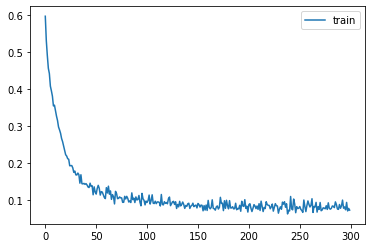

In [39]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 2
Number of indicators 8
              precision    recall  f1-score   support

           S    0.97194   0.96040   0.96614       505
           B    0.96008   0.97172   0.96586       495

    accuracy                        0.96600      1000
   macro avg    0.96601   0.96606   0.96600      1000
weighted avg    0.96607   0.96600   0.96600      1000

Confusion matrix, without normalization
[[485  20]
 [ 14 481]]


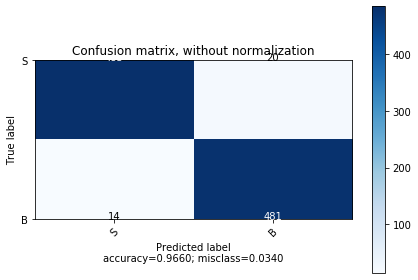

In [40]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 0s 98us/step - loss: 0.6991 - accuracy: 0.5063
Epoch 2/300
3996/3996 [==============================] - 0s 42us/step - loss: 0.6946 - accuracy: 0.5030
Epoch 3/300
3996/3996 [==============================] - 0s 41us/step - loss: 0.6932 - accuracy: 0.5120
Epoch 4/300
3996/3996 [==============================] - 0s 41us/step - loss: 0.6919 - accuracy: 0.5175
Epoch 5/300
3996/3996 [==============================] - 0s 40us/step - loss: 0.6925 - accuracy: 0.5275
Epoch 6/300
3996/3996 [==============================] - 0s 40us/step - loss: 0.6920 - accuracy: 0.5355
Epoch 7/300
3996/3996 [==============================] - 0s 41us/step - loss: 0.6923 - accuracy: 0.5145
Epoch 8/300
3996/3996 [==============================] - 0s 41us/step - loss: 0.6917 - accuracy: 0.5178
Epoch 9/300
3996/3996 [==============================] - 0s 41us/step - loss: 0.6907 - accuracy: 0.5275
Epoch 10/300
3996/3996 [==============================] - 0s 40u

3996/3996 [==============================] - 0s 53us/step - loss: 0.4664 - accuracy: 0.7420
Epoch 80/300
3996/3996 [==============================] - 0s 42us/step - loss: 0.4341 - accuracy: 0.7538
Epoch 81/300
3996/3996 [==============================] - 0s 40us/step - loss: 0.4457 - accuracy: 0.7467
Epoch 82/300
3996/3996 [==============================] - 0s 49us/step - loss: 0.4593 - accuracy: 0.7442
Epoch 83/300
3996/3996 [==============================] - 0s 48us/step - loss: 0.4446 - accuracy: 0.7510
Epoch 84/300
3996/3996 [==============================] - 0s 37us/step - loss: 0.4468 - accuracy: 0.7420
Epoch 85/300
3996/3996 [==============================] - 0s 38us/step - loss: 0.4485 - accuracy: 0.7410
Epoch 86/300
3996/3996 [==============================] - 0s 48us/step - loss: 0.4395 - accuracy: 0.7513
Epoch 87/300
3996/3996 [==============================] - 0s 52us/step - loss: 0.4444 - accuracy: 0.7422
Epoch 88/300
3996/3996 [==============================] - 0s 40us/st

3996/3996 [==============================] - 0s 42us/step - loss: 0.4130 - accuracy: 0.7437
Epoch 234/300
3996/3996 [==============================] - 0s 40us/step - loss: 0.3906 - accuracy: 0.7700
Epoch 235/300
3996/3996 [==============================] - 0s 40us/step - loss: 0.4220 - accuracy: 0.7420
Epoch 236/300
3996/3996 [==============================] - 0s 41us/step - loss: 0.3990 - accuracy: 0.7480
Epoch 237/300
3996/3996 [==============================] - 0s 41us/step - loss: 0.3705 - accuracy: 0.7755
Epoch 238/300
3996/3996 [==============================] - 0s 40us/step - loss: 0.3788 - accuracy: 0.7758
Epoch 239/300
3996/3996 [==============================] - 0s 39us/step - loss: 0.3640 - accuracy: 0.7840
Epoch 240/300
3996/3996 [==============================] - 0s 40us/step - loss: 0.3558 - accuracy: 0.7930
Epoch 241/300
3996/3996 [==============================] - 0s 40us/step - loss: 0.3820 - accuracy: 0.7683
Epoch 242/300
3996/3996 [==============================] - 0

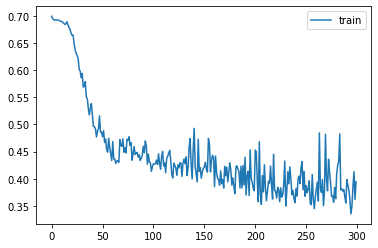

In [41]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 5
Number of indicators 3
              precision    recall  f1-score   support

           S    0.89576   0.96756   0.93028       524
           B    0.96083   0.87605   0.91648       476

    accuracy                        0.92400      1000
   macro avg    0.92829   0.92180   0.92338      1000
weighted avg    0.92673   0.92400   0.92371      1000

Confusion matrix, without normalization
[[507  17]
 [ 59 417]]


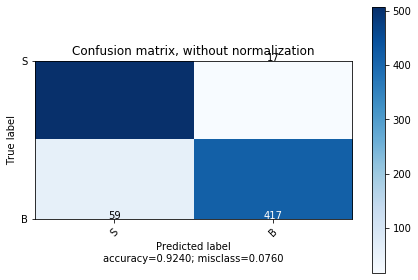

In [42]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 0s 98us/step - loss: 0.5817 - accuracy: 0.6952
Epoch 2/300
3996/3996 [==============================] - 0s 43us/step - loss: 0.5414 - accuracy: 0.7387
Epoch 3/300
3996/3996 [==============================] - 0s 42us/step - loss: 0.5285 - accuracy: 0.7470
Epoch 4/300
3996/3996 [==============================] - 0s 42us/step - loss: 0.5111 - accuracy: 0.7585
Epoch 5/300
3996/3996 [==============================] - 0s 41us/step - loss: 0.5106 - accuracy: 0.7583
Epoch 6/300
3996/3996 [==============================] - 0s 44us/step - loss: 0.5045 - accuracy: 0.7618
Epoch 7/300
3996/3996 [==============================] - 0s 42us/step - loss: 0.5011 - accuracy: 0.7685
Epoch 8/300
3996/3996 [==============================] - 0s 44us/step - loss: 0.5004 - accuracy: 0.7720
Epoch 9/300
3996/3996 [==============================] - 0s 45us/step - loss: 0.4910 - accuracy: 0.7703
Epoch 10/300
3996/3996 [==============================] - 0s 43u

3996/3996 [==============================] - 0s 45us/step - loss: 0.1438 - accuracy: 0.9412
Epoch 80/300
3996/3996 [==============================] - 0s 40us/step - loss: 0.1523 - accuracy: 0.9344
Epoch 81/300
3996/3996 [==============================] - 0s 39us/step - loss: 0.1527 - accuracy: 0.9327
Epoch 82/300
3996/3996 [==============================] - 0s 40us/step - loss: 0.1411 - accuracy: 0.9372
Epoch 83/300
3996/3996 [==============================] - 0s 41us/step - loss: 0.1374 - accuracy: 0.9424
Epoch 84/300
3996/3996 [==============================] - 0s 39us/step - loss: 0.1554 - accuracy: 0.9249
Epoch 85/300
3996/3996 [==============================] - 0s 44us/step - loss: 0.1498 - accuracy: 0.9384
Epoch 86/300
3996/3996 [==============================] - 0s 47us/step - loss: 0.1540 - accuracy: 0.9332
Epoch 87/300
3996/3996 [==============================] - 0s 47us/step - loss: 0.1414 - accuracy: 0.9389
Epoch 88/300
3996/3996 [==============================] - 0s 47us/st

3996/3996 [==============================] - 0s 40us/step - loss: 0.1290 - accuracy: 0.9469
Epoch 234/300
3996/3996 [==============================] - 0s 40us/step - loss: 0.1232 - accuracy: 0.9442
Epoch 235/300
3996/3996 [==============================] - 0s 40us/step - loss: 0.1335 - accuracy: 0.9447
Epoch 236/300
3996/3996 [==============================] - 0s 38us/step - loss: 0.1100 - accuracy: 0.9545
Epoch 237/300
3996/3996 [==============================] - 0s 37us/step - loss: 0.1032 - accuracy: 0.9600
Epoch 238/300
3996/3996 [==============================] - 0s 38us/step - loss: 0.1279 - accuracy: 0.9434
Epoch 239/300
3996/3996 [==============================] - 0s 37us/step - loss: 0.1137 - accuracy: 0.9525
Epoch 240/300
3996/3996 [==============================] - 0s 38us/step - loss: 0.1136 - accuracy: 0.9552
Epoch 241/300
3996/3996 [==============================] - 0s 38us/step - loss: 0.1268 - accuracy: 0.9469
Epoch 242/300
3996/3996 [==============================] - 0

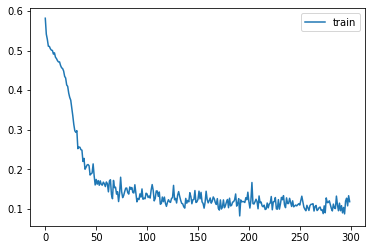

In [43]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 5
Number of indicators 6
              precision    recall  f1-score   support

           S    0.98069   0.96947   0.97505       524
           B    0.96680   0.97899   0.97286       476

    accuracy                        0.97400      1000
   macro avg    0.97375   0.97423   0.97395      1000
weighted avg    0.97408   0.97400   0.97401      1000

Confusion matrix, without normalization
[[508  16]
 [ 10 466]]


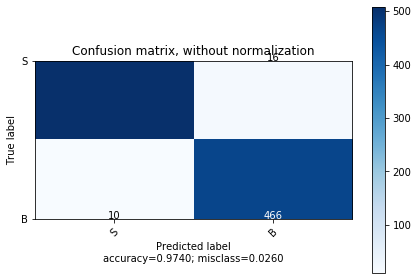

In [44]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 0s 104us/step - loss: 0.5652 - accuracy: 0.7070
Epoch 2/300
3996/3996 [==============================] - 0s 45us/step - loss: 0.5151 - accuracy: 0.7550
Epoch 3/300
3996/3996 [==============================] - 0s 44us/step - loss: 0.5001 - accuracy: 0.7695
Epoch 4/300
3996/3996 [==============================] - 0s 43us/step - loss: 0.4924 - accuracy: 0.7740
Epoch 5/300
3996/3996 [==============================] - 0s 43us/step - loss: 0.4767 - accuracy: 0.7703
Epoch 6/300
3996/3996 [==============================] - 0s 45us/step - loss: 0.4584 - accuracy: 0.7963
Epoch 7/300
3996/3996 [==============================] - 0s 50us/step - loss: 0.4563 - accuracy: 0.7973
Epoch 8/300
3996/3996 [==============================] - 0s 47us/step - loss: 0.4392 - accuracy: 0.7963
Epoch 9/300
3996/3996 [==============================] - 0s 44us/step - loss: 0.4410 - accuracy: 0.8066
Epoch 10/300
3996/3996 [==============================] - 0s 41

3996/3996 [==============================] - 0s 36us/step - loss: 0.1992 - accuracy: 0.9134
Epoch 80/300
3996/3996 [==============================] - 0s 35us/step - loss: 0.1949 - accuracy: 0.9192
Epoch 81/300
3996/3996 [==============================] - 0s 35us/step - loss: 0.1844 - accuracy: 0.9237
Epoch 82/300
3996/3996 [==============================] - 0s 34us/step - loss: 0.1848 - accuracy: 0.9192
Epoch 83/300
3996/3996 [==============================] - 0s 34us/step - loss: 0.2003 - accuracy: 0.9209
Epoch 84/300
3996/3996 [==============================] - 0s 35us/step - loss: 0.1811 - accuracy: 0.9204
Epoch 85/300
3996/3996 [==============================] - 0s 34us/step - loss: 0.1767 - accuracy: 0.9242
Epoch 86/300
3996/3996 [==============================] - 0s 35us/step - loss: 0.1888 - accuracy: 0.9184
Epoch 87/300
3996/3996 [==============================] - 0s 36us/step - loss: 0.1900 - accuracy: 0.9144
Epoch 88/300
3996/3996 [==============================] - 0s 36us/st

3996/3996 [==============================] - 0s 55us/step - loss: 0.1161 - accuracy: 0.9532
Epoch 234/300
3996/3996 [==============================] - 0s 45us/step - loss: 0.1215 - accuracy: 0.9482
Epoch 235/300
3996/3996 [==============================] - 0s 46us/step - loss: 0.1415 - accuracy: 0.9417
Epoch 236/300
3996/3996 [==============================] - 0s 48us/step - loss: 0.1419 - accuracy: 0.9457
Epoch 237/300
3996/3996 [==============================] - 0s 41us/step - loss: 0.1202 - accuracy: 0.9502
Epoch 238/300
3996/3996 [==============================] - 0s 41us/step - loss: 0.1375 - accuracy: 0.9452
Epoch 239/300
3996/3996 [==============================] - 0s 41us/step - loss: 0.1208 - accuracy: 0.9525
Epoch 240/300
3996/3996 [==============================] - 0s 41us/step - loss: 0.1534 - accuracy: 0.9319
Epoch 241/300
3996/3996 [==============================] - 0s 40us/step - loss: 0.1255 - accuracy: 0.9517
Epoch 242/300
3996/3996 [==============================] - 0

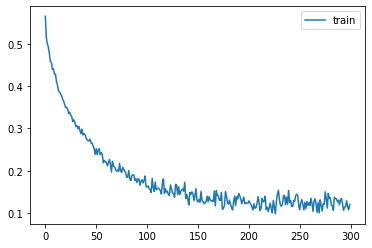

In [45]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 5
Number of indicators 8
              precision    recall  f1-score   support

           S    0.96531   0.90267   0.93294       524
           B    0.90000   0.96429   0.93103       476

    accuracy                        0.93200      1000
   macro avg    0.93265   0.93348   0.93199      1000
weighted avg    0.93422   0.93200   0.93203      1000

Confusion matrix, without normalization
[[473  51]
 [ 17 459]]


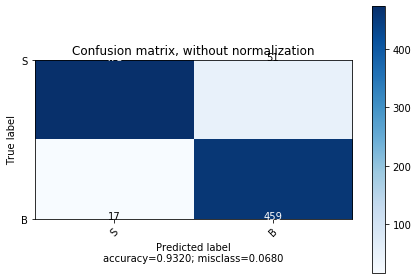

In [46]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 0s 100us/step - loss: 0.6984 - accuracy: 0.5060
Epoch 2/300
3992/3992 [==============================] - 0s 42us/step - loss: 0.6943 - accuracy: 0.4982
Epoch 3/300
3992/3992 [==============================] - 0s 40us/step - loss: 0.6927 - accuracy: 0.5063
Epoch 4/300
3992/3992 [==============================] - 0s 40us/step - loss: 0.6937 - accuracy: 0.4945
Epoch 5/300
3992/3992 [==============================] - 0s 40us/step - loss: 0.6930 - accuracy: 0.5095
Epoch 6/300
3992/3992 [==============================] - 0s 39us/step - loss: 0.6932 - accuracy: 0.5110
Epoch 7/300
3992/3992 [==============================] - 0s 40us/step - loss: 0.6932 - accuracy: 0.5108
Epoch 8/300
3992/3992 [==============================] - 0s 40us/step - loss: 0.6930 - accuracy: 0.5103
Epoch 9/300
3992/3992 [==============================] - 0s 39us/step - loss: 0.6931 - accuracy: 0.5105
Epoch 10/300
3992/3992 [==============================] - 0s 48

3992/3992 [==============================] - 0s 38us/step - loss: 0.6757 - accuracy: 0.5719
Epoch 80/300
3992/3992 [==============================] - 0s 38us/step - loss: 0.6728 - accuracy: 0.5924
Epoch 81/300
3992/3992 [==============================] - 0s 38us/step - loss: 0.6694 - accuracy: 0.5967
Epoch 82/300
3992/3992 [==============================] - 0s 37us/step - loss: 0.6681 - accuracy: 0.6007
Epoch 83/300
3992/3992 [==============================] - 0s 38us/step - loss: 0.6642 - accuracy: 0.6002
Epoch 84/300
3992/3992 [==============================] - 0s 38us/step - loss: 0.6606 - accuracy: 0.6130
Epoch 85/300
3992/3992 [==============================] - 0s 38us/step - loss: 0.6561 - accuracy: 0.6210
Epoch 86/300
3992/3992 [==============================] - 0s 37us/step - loss: 0.6570 - accuracy: 0.6160
Epoch 87/300
3992/3992 [==============================] - 0s 42us/step - loss: 0.6525 - accuracy: 0.6172
Epoch 88/300
3992/3992 [==============================] - 0s 49us/st

3992/3992 [==============================] - 0s 40us/step - loss: 0.5031 - accuracy: 0.7618
Epoch 234/300
3992/3992 [==============================] - 0s 40us/step - loss: 0.5369 - accuracy: 0.7310
Epoch 235/300
3992/3992 [==============================] - 0s 38us/step - loss: 0.5172 - accuracy: 0.7503
Epoch 236/300
3992/3992 [==============================] - 0s 38us/step - loss: 0.5162 - accuracy: 0.7465
Epoch 237/300
3992/3992 [==============================] - 0s 45us/step - loss: 0.4929 - accuracy: 0.7690
Epoch 238/300
3992/3992 [==============================] - 0s 40us/step - loss: 0.5122 - accuracy: 0.7510
Epoch 239/300
3992/3992 [==============================] - 0s 40us/step - loss: 0.5085 - accuracy: 0.7513
Epoch 240/300
3992/3992 [==============================] - 0s 43us/step - loss: 0.5169 - accuracy: 0.7508
Epoch 241/300
3992/3992 [==============================] - 0s 40us/step - loss: 0.5388 - accuracy: 0.7262
Epoch 242/300
3992/3992 [==============================] - 0

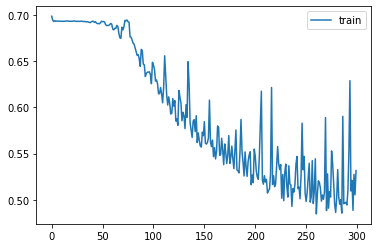

In [47]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 10
Number of indicators 3
              precision    recall  f1-score   support

           S    0.83498   0.98444   0.90357       514
           B    0.97964   0.79381   0.87699       485

    accuracy                        0.89189       999
   macro avg    0.90731   0.88913   0.89028       999
weighted avg    0.90521   0.89189   0.89067       999

Confusion matrix, without normalization
[[506   8]
 [100 385]]


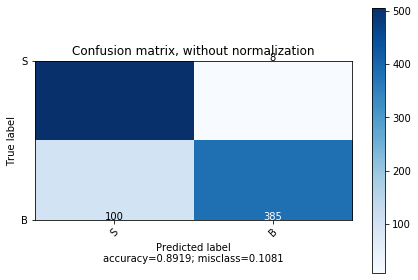

In [48]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 0s 97us/step - loss: 0.6255 - accuracy: 0.6543
Epoch 2/300
3992/3992 [==============================] - 0s 40us/step - loss: 0.5649 - accuracy: 0.7184
Epoch 3/300
3992/3992 [==============================] - 0s 39us/step - loss: 0.5540 - accuracy: 0.7260
Epoch 4/300
3992/3992 [==============================] - 0s 39us/step - loss: 0.5463 - accuracy: 0.7275
Epoch 5/300
3992/3992 [==============================] - 0s 38us/step - loss: 0.5396 - accuracy: 0.7415
Epoch 6/300
3992/3992 [==============================] - 0s 39us/step - loss: 0.5315 - accuracy: 0.7392
Epoch 7/300
3992/3992 [==============================] - 0s 39us/step - loss: 0.5315 - accuracy: 0.7445
Epoch 8/300
3992/3992 [==============================] - 0s 38us/step - loss: 0.5240 - accuracy: 0.7505
Epoch 9/300
3992/3992 [==============================] - 0s 38us/step - loss: 0.5201 - accuracy: 0.7475
Epoch 10/300
3992/3992 [==============================] - 0s 41u

3992/3992 [==============================] - 0s 37us/step - loss: 0.2514 - accuracy: 0.8910
Epoch 80/300
3992/3992 [==============================] - 0s 37us/step - loss: 0.2271 - accuracy: 0.9046
Epoch 81/300
3992/3992 [==============================] - 0s 37us/step - loss: 0.2403 - accuracy: 0.8970
Epoch 82/300
3992/3992 [==============================] - 0s 38us/step - loss: 0.2584 - accuracy: 0.8860
Epoch 83/300
3992/3992 [==============================] - 0s 37us/step - loss: 0.2136 - accuracy: 0.9091
Epoch 84/300
3992/3992 [==============================] - 0s 37us/step - loss: 0.2283 - accuracy: 0.9088
Epoch 85/300
3992/3992 [==============================] - 0s 37us/step - loss: 0.2230 - accuracy: 0.9056
Epoch 86/300
3992/3992 [==============================] - 0s 37us/step - loss: 0.2458 - accuracy: 0.9006
Epoch 87/300
3992/3992 [==============================] - 0s 37us/step - loss: 0.2247 - accuracy: 0.8950
Epoch 88/300
3992/3992 [==============================] - 0s 37us/st

3992/3992 [==============================] - 0s 37us/step - loss: 0.1564 - accuracy: 0.9334
Epoch 234/300
3992/3992 [==============================] - 0s 38us/step - loss: 0.1500 - accuracy: 0.9404
Epoch 235/300
3992/3992 [==============================] - 0s 36us/step - loss: 0.1688 - accuracy: 0.9309
Epoch 236/300
3992/3992 [==============================] - 0s 37us/step - loss: 0.1599 - accuracy: 0.9331
Epoch 237/300
3992/3992 [==============================] - 0s 37us/step - loss: 0.1514 - accuracy: 0.9374
Epoch 238/300
3992/3992 [==============================] - 0s 37us/step - loss: 0.1640 - accuracy: 0.9316
Epoch 239/300
3992/3992 [==============================] - 0s 37us/step - loss: 0.1548 - accuracy: 0.9399
Epoch 240/300
3992/3992 [==============================] - 0s 37us/step - loss: 0.1292 - accuracy: 0.9436
Epoch 241/300
3992/3992 [==============================] - 0s 38us/step - loss: 0.1544 - accuracy: 0.9324
Epoch 242/300
3992/3992 [==============================] - 0

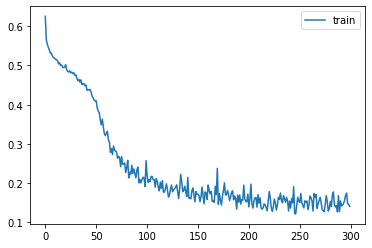

In [49]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 10
Number of indicators 6
              precision    recall  f1-score   support

           S    0.95340   0.95525   0.95432       514
           B    0.95248   0.95052   0.95150       485

    accuracy                        0.95295       999
   macro avg    0.95294   0.95288   0.95291       999
weighted avg    0.95295   0.95295   0.95295       999

Confusion matrix, without normalization
[[491  23]
 [ 24 461]]


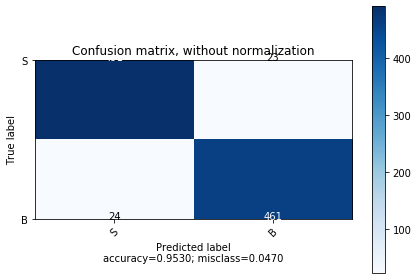

In [50]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 0s 99us/step - loss: 0.6209 - accuracy: 0.6688
Epoch 2/300
3992/3992 [==============================] - 0s 38us/step - loss: 0.5586 - accuracy: 0.7144
Epoch 3/300
3992/3992 [==============================] - 0s 39us/step - loss: 0.5436 - accuracy: 0.7340
Epoch 4/300
3992/3992 [==============================] - 0s 38us/step - loss: 0.5279 - accuracy: 0.7452
Epoch 5/300
3992/3992 [==============================] - 0s 40us/step - loss: 0.5203 - accuracy: 0.7497
Epoch 6/300
3992/3992 [==============================] - 0s 38us/step - loss: 0.5185 - accuracy: 0.7593
Epoch 7/300
3992/3992 [==============================] - 0s 45us/step - loss: 0.5086 - accuracy: 0.7585
Epoch 8/300
3992/3992 [==============================] - 0s 45us/step - loss: 0.4986 - accuracy: 0.7635
Epoch 9/300
3992/3992 [==============================] - 0s 46us/step - loss: 0.5009 - accuracy: 0.7668
Epoch 10/300
3992/3992 [==============================] - 0s 41u

3992/3992 [==============================] - 0s 38us/step - loss: 0.3089 - accuracy: 0.8637
Epoch 80/300
3992/3992 [==============================] - 0s 37us/step - loss: 0.3018 - accuracy: 0.8685
Epoch 81/300
3992/3992 [==============================] - 0s 38us/step - loss: 0.2969 - accuracy: 0.8692
Epoch 82/300
3992/3992 [==============================] - 0s 38us/step - loss: 0.2999 - accuracy: 0.8680
Epoch 83/300
3992/3992 [==============================] - 0s 38us/step - loss: 0.2991 - accuracy: 0.8717
Epoch 84/300
3992/3992 [==============================] - 0s 36us/step - loss: 0.2948 - accuracy: 0.8672
Epoch 85/300
3992/3992 [==============================] - 0s 38us/step - loss: 0.2820 - accuracy: 0.8790
Epoch 86/300
3992/3992 [==============================] - 0s 37us/step - loss: 0.2894 - accuracy: 0.8755
Epoch 87/300
3992/3992 [==============================] - 0s 37us/step - loss: 0.2868 - accuracy: 0.8722
Epoch 88/300
3992/3992 [==============================] - 0s 38us/st

3992/3992 [==============================] - 0s 40us/step - loss: 0.1581 - accuracy: 0.9344
Epoch 234/300
3992/3992 [==============================] - 0s 40us/step - loss: 0.1833 - accuracy: 0.9216
Epoch 235/300
3992/3992 [==============================] - 0s 40us/step - loss: 0.1705 - accuracy: 0.9281
Epoch 236/300
3992/3992 [==============================] - 0s 40us/step - loss: 0.1655 - accuracy: 0.9324
Epoch 237/300
3992/3992 [==============================] - 0s 42us/step - loss: 0.1552 - accuracy: 0.9339
Epoch 238/300
3992/3992 [==============================] - 0s 61us/step - loss: 0.1352 - accuracy: 0.9454
Epoch 239/300
3992/3992 [==============================] - 0s 44us/step - loss: 0.1310 - accuracy: 0.9421
Epoch 240/300
3992/3992 [==============================] - 0s 40us/step - loss: 0.1684 - accuracy: 0.9319
Epoch 241/300
3992/3992 [==============================] - 0s 39us/step - loss: 0.1508 - accuracy: 0.9346
Epoch 242/300
3992/3992 [==============================] - 0

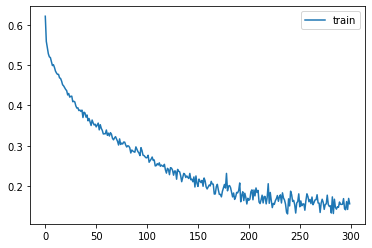

In [51]:
fit(m, c, s, i)

Model mlp
Number of classes 2
Number of steps 10
Number of indicators 8
              precision    recall  f1-score   support

           S    0.97137   0.92412   0.94716       514
           B    0.92353   0.97113   0.94673       485

    accuracy                        0.94695       999
   macro avg    0.94745   0.94763   0.94695       999
weighted avg    0.94814   0.94695   0.94695       999

Confusion matrix, without normalization
[[475  39]
 [ 14 471]]


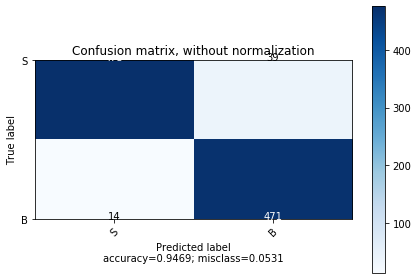

In [52]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 0s 91us/step - loss: 2.0737 - accuracy: 0.1625
Epoch 2/300
3999/3999 [==============================] - 0s 44us/step - loss: 2.0649 - accuracy: 0.1600
Epoch 3/300
3999/3999 [==============================] - 0s 40us/step - loss: 2.0614 - accuracy: 0.1638
Epoch 4/300
3999/3999 [==============================] - 0s 38us/step - loss: 2.0588 - accuracy: 0.1620
Epoch 5/300
3999/3999 [==============================] - 0s 39us/step - loss: 2.0608 - accuracy: 0.1593
Epoch 6/300
3999/3999 [==============================] - 0s 40us/step - loss: 2.0603 - accuracy: 0.1655
Epoch 7/300
3999/3999 [==============================] - 0s 45us/step - loss: 2.0599 - accuracy: 0.1610
Epoch 8/300
3999/3999 [==============================] - 0s 40us/step - loss: 2.0591 - accuracy: 0.1648
Epoch 9/300
3999/3999 [==============================] - 0s 38us/step - loss: 2.0586 - accuracy: 0.1668
Epoch 10/300
3999/3999 [==============================] - 0s 45u

3999/3999 [==============================] - 0s 38us/step - loss: 1.1076 - accuracy: 0.5439
Epoch 80/300
3999/3999 [==============================] - 0s 49us/step - loss: 1.0972 - accuracy: 0.5266
Epoch 81/300
3999/3999 [==============================] - 0s 44us/step - loss: 1.1066 - accuracy: 0.5284
Epoch 82/300
3999/3999 [==============================] - 0s 38us/step - loss: 1.0716 - accuracy: 0.5509
Epoch 83/300
3999/3999 [==============================] - 0s 39us/step - loss: 1.0743 - accuracy: 0.5494
Epoch 84/300
3999/3999 [==============================] - 0s 36us/step - loss: 1.0733 - accuracy: 0.5544
Epoch 85/300
3999/3999 [==============================] - 0s 38us/step - loss: 1.0745 - accuracy: 0.5456
Epoch 86/300
3999/3999 [==============================] - 0s 40us/step - loss: 1.0767 - accuracy: 0.5489
Epoch 87/300
3999/3999 [==============================] - 0s 40us/step - loss: 1.0549 - accuracy: 0.5631
Epoch 88/300
3999/3999 [==============================] - 0s 40us/st

3999/3999 [==============================] - 0s 47us/step - loss: 0.9525 - accuracy: 0.5814
Epoch 234/300
3999/3999 [==============================] - 0s 40us/step - loss: 0.8713 - accuracy: 0.6344
Epoch 235/300
3999/3999 [==============================] - 0s 37us/step - loss: 0.8954 - accuracy: 0.6202
Epoch 236/300
3999/3999 [==============================] - 0s 37us/step - loss: 0.9004 - accuracy: 0.6167
Epoch 237/300
3999/3999 [==============================] - 0s 36us/step - loss: 0.8678 - accuracy: 0.6324
Epoch 238/300
3999/3999 [==============================] - 0s 38us/step - loss: 0.8481 - accuracy: 0.6417
Epoch 239/300
3999/3999 [==============================] - 0s 38us/step - loss: 0.8671 - accuracy: 0.6299
Epoch 240/300
3999/3999 [==============================] - 0s 36us/step - loss: 0.8818 - accuracy: 0.6177
Epoch 241/300
3999/3999 [==============================] - 0s 36us/step - loss: 0.8615 - accuracy: 0.6269
Epoch 242/300
3999/3999 [==============================] - 0

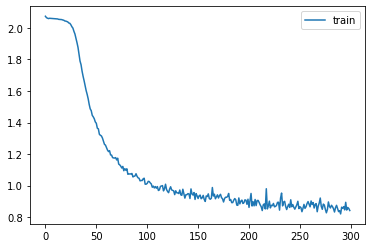

In [53]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 2
Number of indicators 3
              precision    recall  f1-score   support

          B3    0.93000   0.95876   0.94416        97
          B2    0.66176   0.86538   0.75000       104
          B1    0.82927   0.47552   0.60444       143
          B0    0.75000   0.69536   0.72165       151
          S0    0.79231   0.61677   0.69360       167
          S1    0.91549   0.52846   0.67010       123
          S2    0.94615   0.92481   0.93536       133
          S3    1.00000   0.87805   0.93506        82

   micro avg    0.83508   0.71900   0.77270      1000
   macro avg    0.85312   0.74289   0.78180      1000
weighted avg    0.84363   0.71900   0.76432      1000
 samples avg    0.71900   0.71900   0.71900      1000

Confusion matrix, without normalization
[[ 95   2   0   0   0   0   0   0]
 [ 13  90   0   0   1   0   0   0]
 [ 30  44  68   1   0   0   0   0]
 [ 30   0  14 105   2   0   0   0]
 [ 25   0   0  34 103   5   0   0]
 [ 28   0

/Users/kisdev/anaconda3/envs/mc030/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


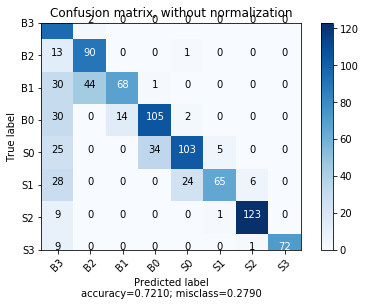

In [54]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 0s 86us/step - loss: 1.9833 - accuracy: 0.1980
Epoch 2/300
3999/3999 [==============================] - 0s 43us/step - loss: 1.9108 - accuracy: 0.1973
Epoch 3/300
3999/3999 [==============================] - 0s 46us/step - loss: 1.8816 - accuracy: 0.2231
Epoch 4/300
3999/3999 [==============================] - 0s 43us/step - loss: 1.8661 - accuracy: 0.2333
Epoch 5/300
3999/3999 [==============================] - 0s 43us/step - loss: 1.8503 - accuracy: 0.2358
Epoch 6/300
3999/3999 [==============================] - 0s 46us/step - loss: 1.8268 - accuracy: 0.2598
Epoch 7/300
3999/3999 [==============================] - 0s 42us/step - loss: 1.7953 - accuracy: 0.2608
Epoch 8/300
3999/3999 [==============================] - 0s 46us/step - loss: 1.7627 - accuracy: 0.2748
Epoch 9/300
3999/3999 [==============================] - 0s 43us/step - loss: 1.7009 - accuracy: 0.3083
Epoch 10/300
3999/3999 [==============================] - 0s 42u

3999/3999 [==============================] - 0s 40us/step - loss: 1.0220 - accuracy: 0.5446
Epoch 80/300
3999/3999 [==============================] - 0s 40us/step - loss: 1.0534 - accuracy: 0.5326
Epoch 81/300
3999/3999 [==============================] - 0s 41us/step - loss: 1.0320 - accuracy: 0.5334
Epoch 82/300
3999/3999 [==============================] - 0s 46us/step - loss: 1.0404 - accuracy: 0.5371
Epoch 83/300
3999/3999 [==============================] - 0s 45us/step - loss: 1.0285 - accuracy: 0.5436
Epoch 84/300
3999/3999 [==============================] - 0s 46us/step - loss: 1.0358 - accuracy: 0.5241
Epoch 85/300
3999/3999 [==============================] - 0s 47us/step - loss: 1.0361 - accuracy: 0.5341
Epoch 86/300
3999/3999 [==============================] - 0s 46us/step - loss: 1.0153 - accuracy: 0.5456
Epoch 87/300
3999/3999 [==============================] - 0s 46us/step - loss: 1.0185 - accuracy: 0.5484
Epoch 88/300
3999/3999 [==============================] - 0s 46us/st

3999/3999 [==============================] - 0s 41us/step - loss: 0.9235 - accuracy: 0.5896
Epoch 234/300
3999/3999 [==============================] - 0s 39us/step - loss: 0.8996 - accuracy: 0.5959
Epoch 235/300
3999/3999 [==============================] - 0s 40us/step - loss: 0.9185 - accuracy: 0.5906
Epoch 236/300
3999/3999 [==============================] - 0s 38us/step - loss: 0.8990 - accuracy: 0.5946
Epoch 237/300
3999/3999 [==============================] - 0s 37us/step - loss: 0.9079 - accuracy: 0.5971
Epoch 238/300
3999/3999 [==============================] - 0s 37us/step - loss: 0.8912 - accuracy: 0.6139
Epoch 239/300
3999/3999 [==============================] - 0s 37us/step - loss: 0.8889 - accuracy: 0.6122
Epoch 240/300
3999/3999 [==============================] - 0s 40us/step - loss: 0.8989 - accuracy: 0.5976
Epoch 241/300
3999/3999 [==============================] - 0s 37us/step - loss: 0.8943 - accuracy: 0.5969
Epoch 242/300
3999/3999 [==============================] - 0

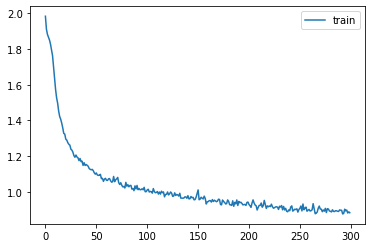

In [55]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 2
Number of indicators 6
              precision    recall  f1-score   support

          B3    0.80412   0.80412   0.80412        97
          B2    0.48214   0.25962   0.33750       104
          B1    0.66038   0.24476   0.35714       143
          B0    0.81560   0.76159   0.78767       151
          S0    0.84328   0.67665   0.75083       167
          S1    0.64000   0.26016   0.36994       123
          S2    0.70492   0.32331   0.44330       133
          S3    0.68182   0.54878   0.60811        82

   micro avg    0.74164   0.48800   0.58866      1000
   macro avg    0.70403   0.48487   0.55733      1000
weighted avg    0.71494   0.48800   0.56283      1000
 samples avg    0.48800   0.48800   0.48800      1000

Confusion matrix, without normalization
[[ 90   7   0   0   0   0   0   0]
 [ 68  27   8   1   0   0   0   0]
 [ 80  22  35   6   0   0   0   0]
 [ 26   0  10 115   0   0   0   0]
 [ 28   0   0  19 113   7   0   0]
 [ 61   0

/Users/kisdev/anaconda3/envs/mc030/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


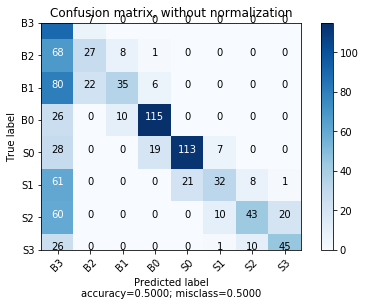

In [56]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 0s 89us/step - loss: 1.9633 - accuracy: 0.1985
Epoch 2/300
3999/3999 [==============================] - 0s 51us/step - loss: 1.8630 - accuracy: 0.2301
Epoch 3/300
3999/3999 [==============================] - 0s 46us/step - loss: 1.8124 - accuracy: 0.2508
Epoch 4/300
3999/3999 [==============================] - 0s 39us/step - loss: 1.7635 - accuracy: 0.2791
Epoch 5/300
3999/3999 [==============================] - 0s 42us/step - loss: 1.7177 - accuracy: 0.2878
Epoch 6/300
3999/3999 [==============================] - 0s 44us/step - loss: 1.6718 - accuracy: 0.3108
Epoch 7/300
3999/3999 [==============================] - 0s 45us/step - loss: 1.6432 - accuracy: 0.3051
Epoch 8/300
3999/3999 [==============================] - 0s 43us/step - loss: 1.6050 - accuracy: 0.3276
Epoch 9/300
3999/3999 [==============================] - 0s 42us/step - loss: 1.5759 - accuracy: 0.3436
Epoch 10/300
3999/3999 [==============================] - 0s 40u

3999/3999 [==============================] - 0s 35us/step - loss: 0.9977 - accuracy: 0.5649
Epoch 80/300
3999/3999 [==============================] - 0s 34us/step - loss: 0.9980 - accuracy: 0.5701
Epoch 81/300
3999/3999 [==============================] - 0s 36us/step - loss: 1.0011 - accuracy: 0.5556
Epoch 82/300
3999/3999 [==============================] - 0s 36us/step - loss: 0.9838 - accuracy: 0.5714
Epoch 83/300
3999/3999 [==============================] - 0s 38us/step - loss: 0.9929 - accuracy: 0.5629
Epoch 84/300
3999/3999 [==============================] - 0s 32us/step - loss: 0.9858 - accuracy: 0.5664
Epoch 85/300
3999/3999 [==============================] - 0s 35us/step - loss: 0.9821 - accuracy: 0.5686
Epoch 86/300
3999/3999 [==============================] - 0s 34us/step - loss: 0.9938 - accuracy: 0.5681
Epoch 87/300
3999/3999 [==============================] - 0s 32us/step - loss: 0.9929 - accuracy: 0.5691
Epoch 88/300
3999/3999 [==============================] - 0s 32us/st

3999/3999 [==============================] - 0s 34us/step - loss: 0.8722 - accuracy: 0.6189
Epoch 234/300
3999/3999 [==============================] - 0s 35us/step - loss: 0.8532 - accuracy: 0.6282
Epoch 235/300
3999/3999 [==============================] - 0s 34us/step - loss: 0.8506 - accuracy: 0.6227
Epoch 236/300
3999/3999 [==============================] - 0s 36us/step - loss: 0.8574 - accuracy: 0.6387
Epoch 237/300
3999/3999 [==============================] - 0s 40us/step - loss: 0.8738 - accuracy: 0.6172
Epoch 238/300
3999/3999 [==============================] - 0s 36us/step - loss: 0.8682 - accuracy: 0.6217
Epoch 239/300
3999/3999 [==============================] - 0s 34us/step - loss: 0.8642 - accuracy: 0.6339
Epoch 240/300
3999/3999 [==============================] - 0s 35us/step - loss: 0.8531 - accuracy: 0.6269
Epoch 241/300
3999/3999 [==============================] - 0s 35us/step - loss: 0.8792 - accuracy: 0.6184
Epoch 242/300
3999/3999 [==============================] - 0

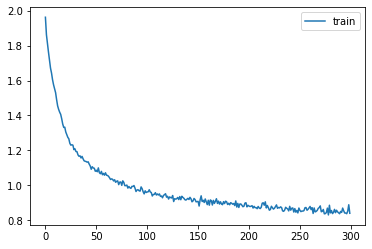

In [57]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 2
Number of indicators 8
              precision    recall  f1-score   support

          B3    0.86747   0.74227   0.80000        97
          B2    0.49524   0.50000   0.49761       104
          B1    0.63889   0.32168   0.42791       143
          B0    0.84848   0.74172   0.79152       151
          S0    0.76647   0.76647   0.76647       167
          S1    0.58824   0.32520   0.41885       123
          S2    0.58889   0.39850   0.47534       133
          S3    0.73438   0.57317   0.64384        82

   micro avg    0.70423   0.55000   0.61763      1000
   macro avg    0.69101   0.54613   0.60269      1000
weighted avg    0.69403   0.55000   0.60559      1000
 samples avg    0.55000   0.55000   0.55000      1000

Confusion matrix, without normalization
[[ 85  12   0   0   0   0   0   0]
 [ 40  52  11   0   1   0   0   0]
 [ 44  41  46  11   1   0   0   0]
 [ 15   0  15 112   9   0   0   0]
 [ 21   0   0   9 128   9   0   0]
 [ 39   0

/Users/kisdev/anaconda3/envs/mc030/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


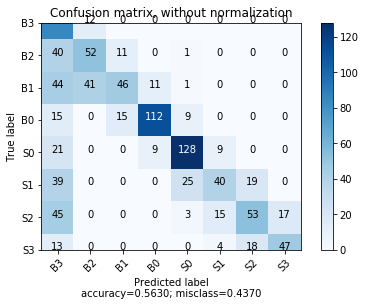

In [58]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 0s 99us/step - loss: 2.0736 - accuracy: 0.1441
Epoch 2/300
3996/3996 [==============================] - 0s 65us/step - loss: 2.0647 - accuracy: 0.1687
Epoch 3/300
3996/3996 [==============================] - 0s 40us/step - loss: 2.0605 - accuracy: 0.1699
Epoch 4/300
3996/3996 [==============================] - 0s 34us/step - loss: 2.0615 - accuracy: 0.1622
Epoch 5/300
3996/3996 [==============================] - 0s 35us/step - loss: 2.0610 - accuracy: 0.1614
Epoch 6/300
3996/3996 [==============================] - 0s 35us/step - loss: 2.0597 - accuracy: 0.1577
Epoch 7/300
3996/3996 [==============================] - 0s 37us/step - loss: 2.0586 - accuracy: 0.1522
Epoch 8/300
3996/3996 [==============================] - 0s 38us/step - loss: 2.0585 - accuracy: 0.1669
Epoch 9/300
3996/3996 [==============================] - 0s 58us/step - loss: 2.0571 - accuracy: 0.1574
Epoch 10/300
3996/3996 [==============================] - 0s 55u

3996/3996 [==============================] - 0s 33us/step - loss: 1.5834 - accuracy: 0.3571
Epoch 80/300
3996/3996 [==============================] - 0s 33us/step - loss: 1.6489 - accuracy: 0.3266
Epoch 81/300
3996/3996 [==============================] - 0s 35us/step - loss: 1.5877 - accuracy: 0.3493
Epoch 82/300
3996/3996 [==============================] - 0s 35us/step - loss: 1.5717 - accuracy: 0.3594
Epoch 83/300
3996/3996 [==============================] - 0s 34us/step - loss: 1.5691 - accuracy: 0.3646
Epoch 84/300
3996/3996 [==============================] - 0s 34us/step - loss: 1.5501 - accuracy: 0.3756
Epoch 85/300
3996/3996 [==============================] - 0s 33us/step - loss: 1.5470 - accuracy: 0.3746
Epoch 86/300
3996/3996 [==============================] - 0s 33us/step - loss: 1.5458 - accuracy: 0.3634
Epoch 87/300
3996/3996 [==============================] - 0s 34us/step - loss: 1.5544 - accuracy: 0.3659
Epoch 88/300
3996/3996 [==============================] - 0s 34us/st

3996/3996 [==============================] - 0s 60us/step - loss: 1.2742 - accuracy: 0.4815
Epoch 234/300
3996/3996 [==============================] - 0s 54us/step - loss: 1.3087 - accuracy: 0.4492
Epoch 235/300
3996/3996 [==============================] - 0s 57us/step - loss: 1.2759 - accuracy: 0.4610
Epoch 236/300
3996/3996 [==============================] - 0s 59us/step - loss: 1.3038 - accuracy: 0.4580
Epoch 237/300
3996/3996 [==============================] - 0s 60us/step - loss: 1.2926 - accuracy: 0.4572
Epoch 238/300
3996/3996 [==============================] - 0s 66us/step - loss: 1.2404 - accuracy: 0.4882
Epoch 239/300
3996/3996 [==============================] - 0s 54us/step - loss: 1.2878 - accuracy: 0.4640
Epoch 240/300
3996/3996 [==============================] - 0s 57us/step - loss: 1.2306 - accuracy: 0.4920
Epoch 241/300
3996/3996 [==============================] - 0s 52us/step - loss: 1.2874 - accuracy: 0.4710
Epoch 242/300
3996/3996 [==============================] - 0

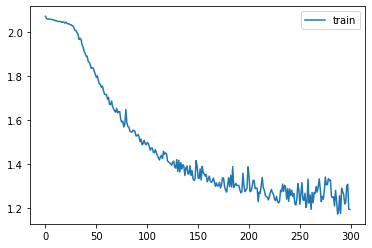

In [59]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 5
Number of indicators 3
              precision    recall  f1-score   support

          B3    0.95312   0.74390   0.83562        82
          B2    1.00000   0.18400   0.31081       125
          B1    0.00000   0.00000   0.00000       125
          B0    1.00000   0.03472   0.06711       144
          S0    0.93333   0.07865   0.14508       178
          S1    0.00000   0.00000   0.00000       124
          S2    0.00000   0.00000   0.00000       130
          S3    0.94444   0.36957   0.53125        92

   micro avg    0.95804   0.13700   0.23972      1000
   macro avg    0.60386   0.17636   0.23623      1000
weighted avg    0.60018   0.13700   0.19174      1000
 samples avg    0.13700   0.13700   0.13700      1000

Confusion matrix, without normalization
[[ 82   0   0   0   0   0   0   0]
 [102  23   0   0   0   0   0   0]
 [125   0   0   0   0   0   0   0]
 [139   0   0   5   0   0   0   0]
 [164   0   0   0  14   0   0   0]
 [123   0

/Users/kisdev/anaconda3/envs/mc030/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kisdev/anaconda3/envs/mc030/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


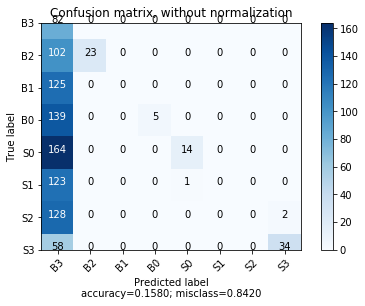

In [60]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 0s 91us/step - loss: 1.9663 - accuracy: 0.2067
Epoch 2/300
3996/3996 [==============================] - 0s 41us/step - loss: 1.8574 - accuracy: 0.2367
Epoch 3/300
3996/3996 [==============================] - 0s 41us/step - loss: 1.8287 - accuracy: 0.2355
Epoch 4/300
3996/3996 [==============================] - 0s 36us/step - loss: 1.8199 - accuracy: 0.2497
Epoch 5/300
3996/3996 [==============================] - 0s 35us/step - loss: 1.8096 - accuracy: 0.2465
Epoch 6/300
3996/3996 [==============================] - 0s 37us/step - loss: 1.7995 - accuracy: 0.2628
Epoch 7/300
3996/3996 [==============================] - 0s 40us/step - loss: 1.7862 - accuracy: 0.2613
Epoch 8/300
3996/3996 [==============================] - 0s 36us/step - loss: 1.7728 - accuracy: 0.2738
Epoch 9/300
3996/3996 [==============================] - 0s 37us/step - loss: 1.7692 - accuracy: 0.2618
Epoch 10/300
3996/3996 [==============================] - 0s 38u

3996/3996 [==============================] - 0s 33us/step - loss: 1.0563 - accuracy: 0.5285
Epoch 156/300
3996/3996 [==============================] - 0s 32us/step - loss: 1.0425 - accuracy: 0.5453
Epoch 157/300
3996/3996 [==============================] - 0s 33us/step - loss: 1.0381 - accuracy: 0.5460
Epoch 158/300
3996/3996 [==============================] - 0s 33us/step - loss: 1.0650 - accuracy: 0.5273
Epoch 159/300
3996/3996 [==============================] - 0s 33us/step - loss: 1.0216 - accuracy: 0.5450
Epoch 160/300
3996/3996 [==============================] - 0s 33us/step - loss: 1.0554 - accuracy: 0.5253
Epoch 161/300
3996/3996 [==============================] - 0s 33us/step - loss: 1.0583 - accuracy: 0.5328
Epoch 162/300
3996/3996 [==============================] - 0s 33us/step - loss: 1.0319 - accuracy: 0.5395
Epoch 163/300
3996/3996 [==============================] - 0s 33us/step - loss: 1.0325 - accuracy: 0.5455
Epoch 164/300
3996/3996 [==============================] - 0

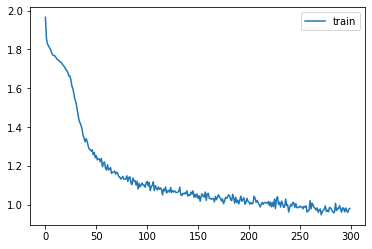

In [61]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 5
Number of indicators 6
              precision    recall  f1-score   support

          B3    0.71642   0.58537   0.64430        82
          B2    0.47826   0.08800   0.14865       125
          B1    0.58065   0.14400   0.23077       125
          B0    0.74820   0.72222   0.73498       144
          S0    0.78846   0.69101   0.73653       178
          S1    0.42105   0.06452   0.11189       124
          S2    0.51852   0.21538   0.30435       130
          S3    0.74419   0.34783   0.47407        92

   micro avg    0.69925   0.37200   0.48564      1000
   macro avg    0.62447   0.35729   0.42319      1000
weighted avg    0.62728   0.37200   0.43425      1000
 samples avg    0.37200   0.37200   0.37200      1000

Confusion matrix, without normalization
[[ 74   6   2   0   0   0   0   0]
 [101  11  10   3   0   0   0   0]
 [ 80   6  18  21   0   0   0   0]
 [ 33   0   1 104   6   0   0   0]
 [ 42   0   0  10 123   3   0   0]
 [ 84   0

/Users/kisdev/anaconda3/envs/mc030/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


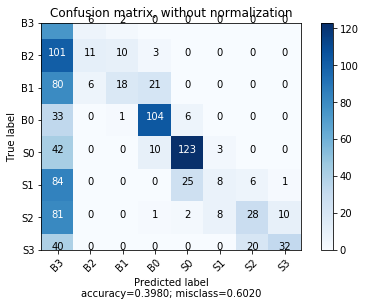

In [62]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 0s 80us/step - loss: 1.9562 - accuracy: 0.2122
Epoch 2/300
3996/3996 [==============================] - 0s 35us/step - loss: 1.8340 - accuracy: 0.2397
Epoch 3/300
3996/3996 [==============================] - 0s 36us/step - loss: 1.7944 - accuracy: 0.2588
Epoch 4/300
3996/3996 [==============================] - 0s 34us/step - loss: 1.7679 - accuracy: 0.2733
Epoch 5/300
3996/3996 [==============================] - 0s 35us/step - loss: 1.7513 - accuracy: 0.2713
Epoch 6/300
3996/3996 [==============================] - 0s 34us/step - loss: 1.7218 - accuracy: 0.2815
Epoch 7/300
3996/3996 [==============================] - 0s 35us/step - loss: 1.7009 - accuracy: 0.2923
Epoch 8/300
3996/3996 [==============================] - 0s 35us/step - loss: 1.6850 - accuracy: 0.3033
Epoch 9/300
3996/3996 [==============================] - 0s 34us/step - loss: 1.6533 - accuracy: 0.3063
Epoch 10/300
3996/3996 [==============================] - 0s 35u

3996/3996 [==============================] - 0s 34us/step - loss: 1.1406 - accuracy: 0.4992
Epoch 80/300
3996/3996 [==============================] - 0s 34us/step - loss: 1.1504 - accuracy: 0.5030
Epoch 81/300
3996/3996 [==============================] - 0s 34us/step - loss: 1.1146 - accuracy: 0.5188
Epoch 82/300
3996/3996 [==============================] - 0s 34us/step - loss: 1.1416 - accuracy: 0.4910
Epoch 83/300
3996/3996 [==============================] - 0s 34us/step - loss: 1.1170 - accuracy: 0.5203
Epoch 84/300
3996/3996 [==============================] - 0s 34us/step - loss: 1.1062 - accuracy: 0.5118
Epoch 85/300
3996/3996 [==============================] - 0s 34us/step - loss: 1.1318 - accuracy: 0.5105
Epoch 86/300
3996/3996 [==============================] - 0s 34us/step - loss: 1.1113 - accuracy: 0.5178
Epoch 87/300
3996/3996 [==============================] - 0s 34us/step - loss: 1.1024 - accuracy: 0.5223
Epoch 88/300
3996/3996 [==============================] - 0s 34us/st

3996/3996 [==============================] - 0s 35us/step - loss: 0.9665 - accuracy: 0.5798
Epoch 234/300
3996/3996 [==============================] - 0s 34us/step - loss: 0.9578 - accuracy: 0.5898
Epoch 235/300
3996/3996 [==============================] - 0s 35us/step - loss: 0.9349 - accuracy: 0.5951
Epoch 236/300
3996/3996 [==============================] - 0s 37us/step - loss: 0.9391 - accuracy: 0.5873
Epoch 237/300
3996/3996 [==============================] - 0s 34us/step - loss: 0.9704 - accuracy: 0.5748
Epoch 238/300
3996/3996 [==============================] - 0s 34us/step - loss: 0.9348 - accuracy: 0.5863
Epoch 239/300
3996/3996 [==============================] - 0s 34us/step - loss: 0.9630 - accuracy: 0.5798
Epoch 240/300
3996/3996 [==============================] - 0s 35us/step - loss: 0.9433 - accuracy: 0.5881
Epoch 241/300
3996/3996 [==============================] - 0s 34us/step - loss: 0.9260 - accuracy: 0.6066
Epoch 242/300
3996/3996 [==============================] - 0

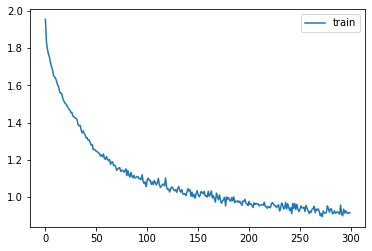

In [63]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 5
Number of indicators 8
              precision    recall  f1-score   support

          B3    0.79710   0.67073   0.72848        82
          B2    0.60000   0.26400   0.36667       125
          B1    0.69231   0.21600   0.32927       125
          B0    0.71186   0.58333   0.64122       144
          S0    0.71257   0.66854   0.68986       178
          S1    0.44615   0.23387   0.30688       124
          S2    0.48315   0.33077   0.39269       130
          S3    0.72000   0.39130   0.50704        92

   micro avg    0.65337   0.42600   0.51574      1000
   macro avg    0.64539   0.41982   0.49526      1000
weighted avg    0.64062   0.42600   0.49761      1000
 samples avg    0.42600   0.42600   0.42600      1000

Confusion matrix, without normalization
[[ 73   8   1   0   0   0   0   0]
 [ 80  33   9   2   1   0   0   0]
 [ 56  14  27  26   1   0   0   1]
 [ 30   0   2  84  28   0   0   0]
 [ 45   0   0   4 119   8   2   0]
 [ 65   0

/Users/kisdev/anaconda3/envs/mc030/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


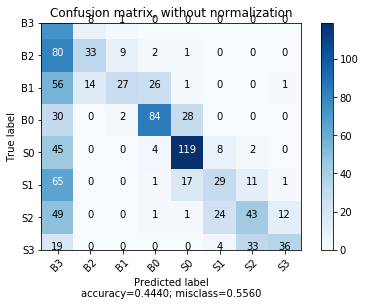

In [64]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 0s 80us/step - loss: 2.0701 - accuracy: 0.1561
Epoch 2/300
3992/3992 [==============================] - 0s 35us/step - loss: 2.0624 - accuracy: 0.1716
Epoch 3/300
3992/3992 [==============================] - 0s 34us/step - loss: 2.0590 - accuracy: 0.1691
Epoch 4/300
3992/3992 [==============================] - 0s 34us/step - loss: 2.0575 - accuracy: 0.1708
Epoch 5/300
3992/3992 [==============================] - 0s 35us/step - loss: 2.0571 - accuracy: 0.1708
Epoch 6/300
3992/3992 [==============================] - 0s 35us/step - loss: 2.0571 - accuracy: 0.1716
Epoch 7/300
3992/3992 [==============================] - 0s 34us/step - loss: 2.0573 - accuracy: 0.1666
Epoch 8/300
3992/3992 [==============================] - 0s 34us/step - loss: 2.0562 - accuracy: 0.1713
Epoch 9/300
3992/3992 [==============================] - 0s 34us/step - loss: 2.0550 - accuracy: 0.1706
Epoch 10/300
3992/3992 [==============================] - 0s 34u

3992/3992 [==============================] - 0s 34us/step - loss: 2.0368 - accuracy: 0.1811
Epoch 80/300
3992/3992 [==============================] - 0s 33us/step - loss: 2.0349 - accuracy: 0.1771
Epoch 81/300
3992/3992 [==============================] - 0s 34us/step - loss: 2.0403 - accuracy: 0.1841
Epoch 82/300
3992/3992 [==============================] - 0s 35us/step - loss: 2.0371 - accuracy: 0.1824
Epoch 83/300
3992/3992 [==============================] - 0s 34us/step - loss: 2.0388 - accuracy: 0.1826
Epoch 84/300
3992/3992 [==============================] - 0s 34us/step - loss: 2.0384 - accuracy: 0.1831
Epoch 85/300
3992/3992 [==============================] - 0s 33us/step - loss: 2.0343 - accuracy: 0.1816
Epoch 86/300
3992/3992 [==============================] - 0s 33us/step - loss: 2.0379 - accuracy: 0.1801
Epoch 87/300
3992/3992 [==============================] - 0s 33us/step - loss: 2.0395 - accuracy: 0.1804
Epoch 88/300
3992/3992 [==============================] - 0s 37us/st

3992/3992 [==============================] - 0s 36us/step - loss: 1.7506 - accuracy: 0.2993
Epoch 234/300
3992/3992 [==============================] - 0s 35us/step - loss: 1.7495 - accuracy: 0.3069
Epoch 235/300
3992/3992 [==============================] - 0s 35us/step - loss: 1.7587 - accuracy: 0.3006
Epoch 236/300
3992/3992 [==============================] - 0s 34us/step - loss: 1.7296 - accuracy: 0.3004
Epoch 237/300
3992/3992 [==============================] - 0s 33us/step - loss: 1.7439 - accuracy: 0.2998
Epoch 238/300
3992/3992 [==============================] - 0s 34us/step - loss: 1.7437 - accuracy: 0.2978
Epoch 239/300
3992/3992 [==============================] - 0s 36us/step - loss: 1.7245 - accuracy: 0.3069
Epoch 240/300
3992/3992 [==============================] - 0s 35us/step - loss: 1.7217 - accuracy: 0.3254
Epoch 241/300
3992/3992 [==============================] - 0s 35us/step - loss: 1.7342 - accuracy: 0.3016
Epoch 242/300
3992/3992 [==============================] - 0

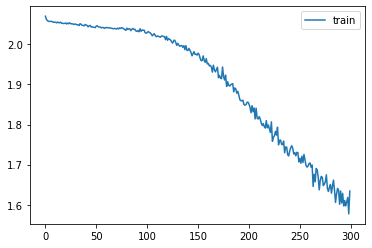

In [65]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 10
Number of indicators 3
              precision    recall  f1-score   support

          B3    1.00000   0.07527   0.14000        93
          B2    0.00000   0.00000   0.00000       124
          B1    0.00000   0.00000   0.00000       125
          B0    0.00000   0.00000   0.00000       143
          S0    0.00000   0.00000   0.00000       148
          S1    0.00000   0.00000   0.00000       139
          S2    0.00000   0.00000   0.00000       131
          S3    0.92857   0.27083   0.41935        96

   micro avg    0.94286   0.03303   0.06383       999
   macro avg    0.24107   0.04326   0.06992       999
weighted avg    0.18233   0.03303   0.05333       999
 samples avg    0.03303   0.03303   0.03303       999

Confusion matrix, without normalization
[[ 93   0   0   0   0   0   0   0]
 [124   0   0   0   0   0   0   0]
 [125   0   0   0   0   0   0   0]
 [142   0   0   0   0   0   0   1]
 [148   0   0   0   0   0   0   0]
 [139   

/Users/kisdev/anaconda3/envs/mc030/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kisdev/anaconda3/envs/mc030/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


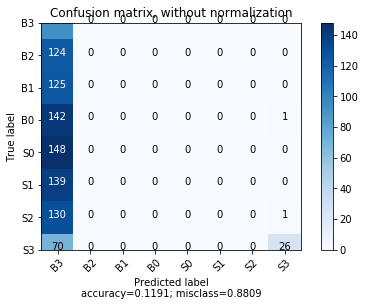

In [66]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 0s 82us/step - loss: 2.0326 - accuracy: 0.1909
Epoch 2/300
3992/3992 [==============================] - 0s 43us/step - loss: 1.9015 - accuracy: 0.2184
Epoch 3/300
3992/3992 [==============================] - 0s 40us/step - loss: 1.8667 - accuracy: 0.2415
Epoch 4/300
3992/3992 [==============================] - 0s 41us/step - loss: 1.8381 - accuracy: 0.2467
Epoch 5/300
3992/3992 [==============================] - 0s 40us/step - loss: 1.8358 - accuracy: 0.2500
Epoch 6/300
3992/3992 [==============================] - 0s 40us/step - loss: 1.8154 - accuracy: 0.2585
Epoch 7/300
3992/3992 [==============================] - 0s 39us/step - loss: 1.7987 - accuracy: 0.2643
Epoch 8/300
3992/3992 [==============================] - 0s 40us/step - loss: 1.8029 - accuracy: 0.2658
Epoch 9/300
3992/3992 [==============================] - 0s 45us/step - loss: 1.7920 - accuracy: 0.2768
Epoch 10/300
3992/3992 [==============================] - 0s 41u

3992/3992 [==============================] - 0s 36us/step - loss: 1.2204 - accuracy: 0.4624
Epoch 80/300
3992/3992 [==============================] - 0s 36us/step - loss: 1.2115 - accuracy: 0.4887
Epoch 81/300
3992/3992 [==============================] - 0s 37us/step - loss: 1.2382 - accuracy: 0.4629
Epoch 82/300
3992/3992 [==============================] - 0s 36us/step - loss: 1.2048 - accuracy: 0.4777
Epoch 83/300
3992/3992 [==============================] - 0s 37us/step - loss: 1.2194 - accuracy: 0.4657
Epoch 84/300
3992/3992 [==============================] - 0s 37us/step - loss: 1.2234 - accuracy: 0.4699
Epoch 85/300
3992/3992 [==============================] - 0s 37us/step - loss: 1.2044 - accuracy: 0.4807
Epoch 86/300
3992/3992 [==============================] - 0s 35us/step - loss: 1.2117 - accuracy: 0.4722
Epoch 87/300
3992/3992 [==============================] - 0s 38us/step - loss: 1.1962 - accuracy: 0.4707
Epoch 88/300
3992/3992 [==============================] - 0s 37us/st

3992/3992 [==============================] - 0s 34us/step - loss: 1.0561 - accuracy: 0.5318
Epoch 234/300
3992/3992 [==============================] - 0s 35us/step - loss: 1.0712 - accuracy: 0.5313
Epoch 235/300
3992/3992 [==============================] - 0s 36us/step - loss: 1.0563 - accuracy: 0.5498
Epoch 236/300
3992/3992 [==============================] - 0s 34us/step - loss: 1.0466 - accuracy: 0.5333
Epoch 237/300
3992/3992 [==============================] - 0s 35us/step - loss: 1.0378 - accuracy: 0.5376
Epoch 238/300
3992/3992 [==============================] - 0s 35us/step - loss: 1.0409 - accuracy: 0.5371
Epoch 239/300
3992/3992 [==============================] - 0s 35us/step - loss: 1.0472 - accuracy: 0.5423
Epoch 240/300
3992/3992 [==============================] - 0s 35us/step - loss: 1.0302 - accuracy: 0.5413
Epoch 241/300
3992/3992 [==============================] - 0s 36us/step - loss: 1.0726 - accuracy: 0.5303
Epoch 242/300
3992/3992 [==============================] - 0

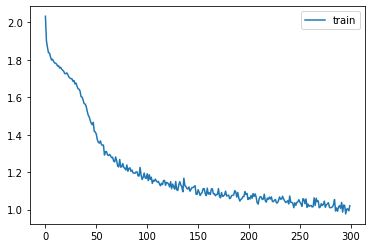

In [67]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 10
Number of indicators 6
              precision    recall  f1-score   support

          B3    0.56164   0.44086   0.49398        93
          B2    0.44828   0.20968   0.28571       124
          B1    0.50000   0.14400   0.22360       125
          B0    0.50877   0.40559   0.45136       143
          S0    0.47328   0.41892   0.44444       148
          S1    0.47059   0.05755   0.10256       139
          S2    0.41304   0.14504   0.21469       131
          S3    0.86207   0.26042   0.40000        96

   micro avg    0.50992   0.25726   0.34198       999
   macro avg    0.52971   0.26026   0.32704       999
weighted avg    0.51591   0.25726   0.32074       999
 samples avg    0.25726   0.25726   0.25726       999

Confusion matrix, without normalization
[[77 14  2  0  0  0  0  0]
 [88 26  9  1  0  0  0  0]
 [87 17 18  3  0  0  0  0]
 [73  1  7 58  4  0  0  0]
 [42  0  0 43 62  1  0  0]
 [75  0  0  5 47  8  4  0]
 [85  0  0  3 16  4 1

/Users/kisdev/anaconda3/envs/mc030/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


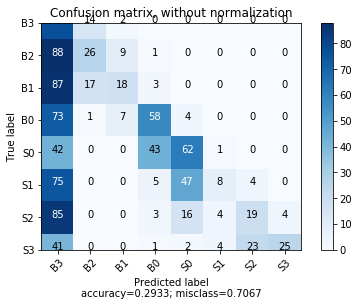

In [68]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 0s 86us/step - loss: 2.0116 - accuracy: 0.1904
Epoch 2/300
3992/3992 [==============================] - 0s 36us/step - loss: 1.8828 - accuracy: 0.2347
Epoch 3/300
3992/3992 [==============================] - 0s 37us/step - loss: 1.8462 - accuracy: 0.2392
Epoch 4/300
3992/3992 [==============================] - 0s 37us/step - loss: 1.8221 - accuracy: 0.2595
Epoch 5/300
3992/3992 [==============================] - 0s 36us/step - loss: 1.8071 - accuracy: 0.2550
Epoch 6/300
3992/3992 [==============================] - 0s 36us/step - loss: 1.7834 - accuracy: 0.2713
Epoch 7/300
3992/3992 [==============================] - 0s 38us/step - loss: 1.7746 - accuracy: 0.2670
Epoch 8/300
3992/3992 [==============================] - 0s 37us/step - loss: 1.7642 - accuracy: 0.2730
Epoch 9/300
3992/3992 [==============================] - 0s 37us/step - loss: 1.7474 - accuracy: 0.2818
Epoch 10/300
3992/3992 [==============================] - 0s 37u

3992/3992 [==============================] - 0s 35us/step - loss: 1.3132 - accuracy: 0.4306
Epoch 80/300
3992/3992 [==============================] - 0s 39us/step - loss: 1.3288 - accuracy: 0.4281
Epoch 81/300
3992/3992 [==============================] - 0s 35us/step - loss: 1.3388 - accuracy: 0.4299
Epoch 82/300
3992/3992 [==============================] - 0s 35us/step - loss: 1.3059 - accuracy: 0.4406
Epoch 83/300
3992/3992 [==============================] - 0s 36us/step - loss: 1.2989 - accuracy: 0.4391
Epoch 84/300
3992/3992 [==============================] - 0s 38us/step - loss: 1.3115 - accuracy: 0.4369
Epoch 85/300
3992/3992 [==============================] - 0s 37us/step - loss: 1.3251 - accuracy: 0.4259
Epoch 86/300
3992/3992 [==============================] - 0s 40us/step - loss: 1.3121 - accuracy: 0.4351
Epoch 87/300
3992/3992 [==============================] - 0s 38us/step - loss: 1.3081 - accuracy: 0.4464
Epoch 88/300
3992/3992 [==============================] - 0s 38us/st

3992/3992 [==============================] - 0s 36us/step - loss: 1.0587 - accuracy: 0.5331
Epoch 234/300
3992/3992 [==============================] - 0s 36us/step - loss: 1.1087 - accuracy: 0.5120
Epoch 235/300
3992/3992 [==============================] - 0s 40us/step - loss: 1.0872 - accuracy: 0.5203
Epoch 236/300
3992/3992 [==============================] - 0s 38us/step - loss: 1.0773 - accuracy: 0.5373
Epoch 237/300
3992/3992 [==============================] - 0s 38us/step - loss: 1.0534 - accuracy: 0.5388
Epoch 238/300
3992/3992 [==============================] - 0s 36us/step - loss: 1.0717 - accuracy: 0.5393
Epoch 239/300
3992/3992 [==============================] - 0s 35us/step - loss: 1.0484 - accuracy: 0.5408
Epoch 240/300
3992/3992 [==============================] - 0s 34us/step - loss: 1.0443 - accuracy: 0.5368
Epoch 241/300
3992/3992 [==============================] - 0s 35us/step - loss: 1.0520 - accuracy: 0.5498
Epoch 242/300
3992/3992 [==============================] - 0

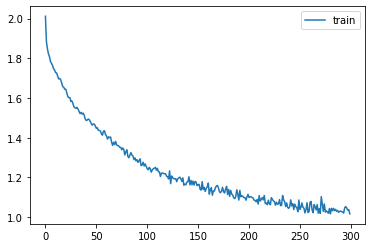

In [69]:
fit(m, c, s, i)

Model mlp
Number of classes 8
Number of steps 10
Number of indicators 8
              precision    recall  f1-score   support

          B3    0.66154   0.46237   0.54430        93
          B2    0.56522   0.20968   0.30588       124
          B1    0.73684   0.11200   0.19444       125
          B0    0.72816   0.52448   0.60976       143
          S0    0.62121   0.55405   0.58571       148
          S1    0.66667   0.04317   0.08108       139
          S2    0.43478   0.22901   0.30000       131
          S3    0.82353   0.29167   0.43077        96

   micro avg    0.63732   0.30430   0.41192       999
   macro avg    0.65474   0.30330   0.38149       999
weighted avg    0.64911   0.30430   0.37904       999
 samples avg    0.30430   0.30430   0.30430       999

Confusion matrix, without normalization
[[77 16  0  0  0  0  0  0]
 [93 26  5  0  0  0  0  0]
 [93  3 14 14  1  0  0  0]
 [63  0  0 75  5  0  0  0]
 [51  0  0 14 82  1  0  0]
 [85  0  0  0 41  6  6  1]
 [91  0  0  0  3  2 3

/Users/kisdev/anaconda3/envs/mc030/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


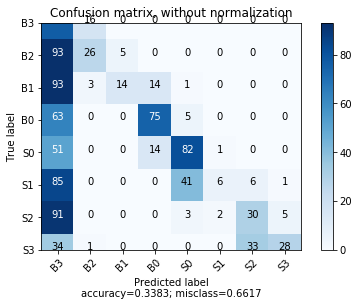

In [70]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 1s 298us/step - loss: 0.6940 - accuracy: 0.4886
Epoch 2/300
3999/3999 [==============================] - 0s 99us/step - loss: 0.6933 - accuracy: 0.5001
Epoch 3/300
3999/3999 [==============================] - 0s 99us/step - loss: 0.6932 - accuracy: 0.4991
Epoch 4/300
3999/3999 [==============================] - 0s 99us/step - loss: 0.6932 - accuracy: 0.4931
Epoch 5/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.6931 - accuracy: 0.5026
Epoch 6/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.6930 - accuracy: 0.5039
Epoch 7/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.6930 - accuracy: 0.5046
Epoch 8/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.6930 - accuracy: 0.5051
Epoch 9/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.6928 - accuracy: 0.5101
Epoch 10/300
3999/3999 [==============================] - 0s 97

3999/3999 [==============================] - 0s 99us/step - loss: 0.1881 - accuracy: 0.9367
Epoch 156/300
3999/3999 [==============================] - 0s 97us/step - loss: 0.1881 - accuracy: 0.9397
Epoch 157/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.1861 - accuracy: 0.9390
Epoch 158/300
3999/3999 [==============================] - 0s 97us/step - loss: 0.1841 - accuracy: 0.9407
Epoch 159/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.1810 - accuracy: 0.9470
Epoch 160/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.1943 - accuracy: 0.9237
Epoch 161/300
3999/3999 [==============================] - 0s 97us/step - loss: 0.1961 - accuracy: 0.9270
Epoch 162/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.2051 - accuracy: 0.9140
Epoch 163/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.1759 - accuracy: 0.9445
Epoch 164/300
3999/3999 [==============================] - 0

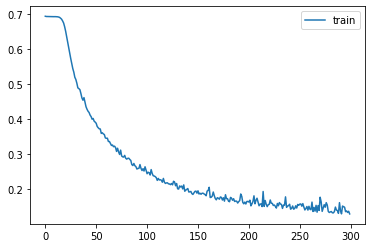

In [71]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 2
Number of indicators 3
              precision    recall  f1-score   support

           S    0.98897   0.96071   0.97464       560
           B    0.95175   0.98636   0.96875       440

    accuracy                        0.97200      1000
   macro avg    0.97036   0.97354   0.97169      1000
weighted avg    0.97260   0.97200   0.97205      1000

Confusion matrix, without normalization
[[538  22]
 [  6 434]]


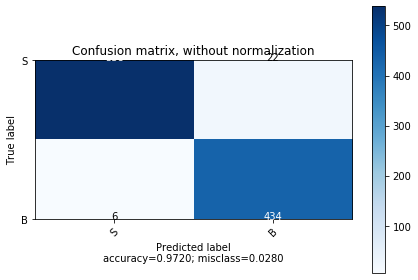

In [72]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 1s 312us/step - loss: 0.5972 - accuracy: 0.6817
Epoch 2/300
3999/3999 [==============================] - 0s 96us/step - loss: 0.5513 - accuracy: 0.7289
Epoch 3/300
3999/3999 [==============================] - 0s 101us/step - loss: 0.4600 - accuracy: 0.8007
Epoch 4/300
3999/3999 [==============================] - 0s 102us/step - loss: 0.3519 - accuracy: 0.8605
Epoch 5/300
3999/3999 [==============================] - 0s 106us/step - loss: 0.2765 - accuracy: 0.9132
Epoch 6/300
3999/3999 [==============================] - 0s 102us/step - loss: 0.2494 - accuracy: 0.9125
Epoch 7/300
3999/3999 [==============================] - 0s 97us/step - loss: 0.2112 - accuracy: 0.9335
Epoch 8/300
3999/3999 [==============================] - 0s 105us/step - loss: 0.1893 - accuracy: 0.9447
Epoch 9/300
3999/3999 [==============================] - 0s 99us/step - loss: 0.1786 - accuracy: 0.9405
Epoch 10/300
3999/3999 [==============================] - 

3999/3999 [==============================] - 0s 101us/step - loss: 0.0576 - accuracy: 0.9772
Epoch 156/300
3999/3999 [==============================] - 0s 104us/step - loss: 0.0576 - accuracy: 0.9772
Epoch 157/300
3999/3999 [==============================] - 0s 100us/step - loss: 0.0613 - accuracy: 0.9770
Epoch 158/300
3999/3999 [==============================] - 0s 100us/step - loss: 0.0454 - accuracy: 0.9832
Epoch 159/300
3999/3999 [==============================] - 0s 101us/step - loss: 0.0640 - accuracy: 0.9730
Epoch 160/300
3999/3999 [==============================] - 0s 108us/step - loss: 0.0507 - accuracy: 0.9792
Epoch 161/300
3999/3999 [==============================] - 0s 121us/step - loss: 0.0490 - accuracy: 0.9815
Epoch 162/300
3999/3999 [==============================] - 0s 107us/step - loss: 0.0473 - accuracy: 0.9835
Epoch 163/300
3999/3999 [==============================] - 0s 105us/step - loss: 0.0446 - accuracy: 0.9835
Epoch 164/300
3999/3999 [==========================

Epoch 232/300
3999/3999 [==============================] - 0s 99us/step - loss: 0.0464 - accuracy: 0.9817
Epoch 233/300
3999/3999 [==============================] - 0s 97us/step - loss: 0.0488 - accuracy: 0.9817
Epoch 234/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.0404 - accuracy: 0.9830
Epoch 235/300
3999/3999 [==============================] - 0s 99us/step - loss: 0.0356 - accuracy: 0.9867
Epoch 236/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.0515 - accuracy: 0.9795
Epoch 237/300
3999/3999 [==============================] - 0s 99us/step - loss: 0.0455 - accuracy: 0.9827
Epoch 238/300
3999/3999 [==============================] - 0s 100us/step - loss: 0.0415 - accuracy: 0.9832
Epoch 239/300
3999/3999 [==============================] - 0s 101us/step - loss: 0.0542 - accuracy: 0.9780
Epoch 240/300
3999/3999 [==============================] - 0s 102us/step - loss: 0.0567 - accuracy: 0.9747
Epoch 241/300
3999/3999 [==================

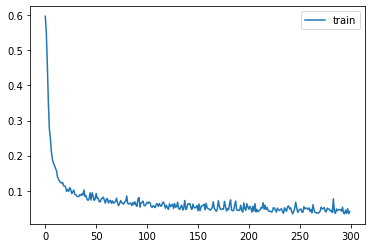

In [73]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 2
Number of indicators 6
              precision    recall  f1-score   support

           S    0.97143   0.97143   0.97143       560
           B    0.96364   0.96364   0.96364       440

    accuracy                        0.96800      1000
   macro avg    0.96753   0.96753   0.96753      1000
weighted avg    0.96800   0.96800   0.96800      1000

Confusion matrix, without normalization
[[544  16]
 [ 16 424]]


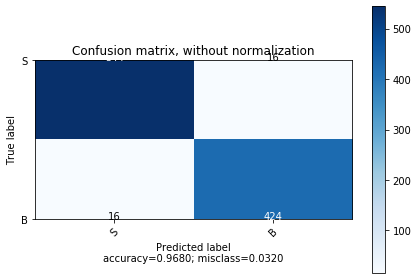

In [74]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 1s 296us/step - loss: 0.5867 - accuracy: 0.6907
Epoch 2/300
3999/3999 [==============================] - 0s 100us/step - loss: 0.4743 - accuracy: 0.7874
Epoch 3/300
3999/3999 [==============================] - 0s 99us/step - loss: 0.4084 - accuracy: 0.8267
Epoch 4/300
3999/3999 [==============================] - 0s 100us/step - loss: 0.3703 - accuracy: 0.8512
Epoch 5/300
3999/3999 [==============================] - 0s 101us/step - loss: 0.3433 - accuracy: 0.8560
Epoch 6/300
3999/3999 [==============================] - 0s 100us/step - loss: 0.3071 - accuracy: 0.8772
Epoch 7/300
3999/3999 [==============================] - 0s 100us/step - loss: 0.2694 - accuracy: 0.8940
Epoch 8/300
3999/3999 [==============================] - 0s 99us/step - loss: 0.2548 - accuracy: 0.9015
Epoch 9/300
3999/3999 [==============================] - 0s 100us/step - loss: 0.2380 - accuracy: 0.9052
Epoch 10/300
3999/3999 [==============================] -

3999/3999 [==============================] - 0s 98us/step - loss: 0.0487 - accuracy: 0.9802
Epoch 156/300
3999/3999 [==============================] - 0s 99us/step - loss: 0.0531 - accuracy: 0.9772
Epoch 157/300
3999/3999 [==============================] - 0s 99us/step - loss: 0.0580 - accuracy: 0.9757
Epoch 158/300
3999/3999 [==============================] - 0s 99us/step - loss: 0.0577 - accuracy: 0.9777
Epoch 159/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.0535 - accuracy: 0.9792
Epoch 160/300
3999/3999 [==============================] - 0s 99us/step - loss: 0.0460 - accuracy: 0.9835
Epoch 161/300
3999/3999 [==============================] - 0s 99us/step - loss: 0.0409 - accuracy: 0.9870
Epoch 162/300
3999/3999 [==============================] - 0s 99us/step - loss: 0.0520 - accuracy: 0.9800
Epoch 163/300
3999/3999 [==============================] - 0s 99us/step - loss: 0.0440 - accuracy: 0.9850
Epoch 164/300
3999/3999 [==============================] - 0

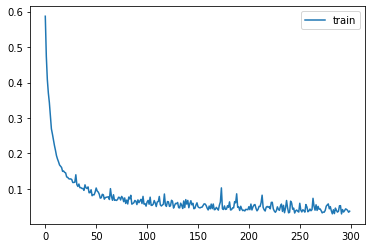

In [75]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 2
Number of indicators 8
              precision    recall  f1-score   support

           S    0.97133   0.96786   0.96959       560
           B    0.95928   0.96364   0.96145       440

    accuracy                        0.96600      1000
   macro avg    0.96530   0.96575   0.96552      1000
weighted avg    0.96602   0.96600   0.96601      1000

Confusion matrix, without normalization
[[542  18]
 [ 16 424]]


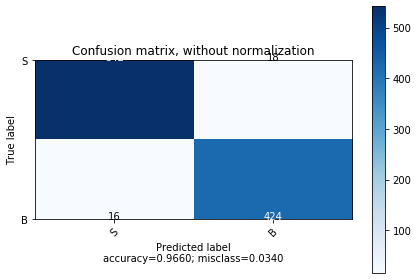

In [76]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 2s 423us/step - loss: 0.6946 - accuracy: 0.5003
Epoch 2/300
3996/3996 [==============================] - 1s 158us/step - loss: 0.6934 - accuracy: 0.5020
Epoch 3/300
3996/3996 [==============================] - 1s 157us/step - loss: 0.6934 - accuracy: 0.5040
Epoch 4/300
3996/3996 [==============================] - 1s 164us/step - loss: 0.6934 - accuracy: 0.5018
Epoch 5/300
3996/3996 [==============================] - 1s 164us/step - loss: 0.6932 - accuracy: 0.5033
Epoch 6/300
3996/3996 [==============================] - 1s 163us/step - loss: 0.6932 - accuracy: 0.5020
Epoch 7/300
3996/3996 [==============================] - 1s 162us/step - loss: 0.6932 - accuracy: 0.4992
Epoch 8/300
3996/3996 [==============================] - 1s 165us/step - loss: 0.6933 - accuracy: 0.5080
Epoch 9/300
3996/3996 [==============================] - 1s 167us/step - loss: 0.6931 - accuracy: 0.5048
Epoch 10/300
3996/3996 [==============================]

3996/3996 [==============================] - 1s 165us/step - loss: 0.2096 - accuracy: 0.9167
Epoch 155/300
3996/3996 [==============================] - 1s 166us/step - loss: 0.1810 - accuracy: 0.9319
Epoch 156/300
3996/3996 [==============================] - 1s 164us/step - loss: 0.2122 - accuracy: 0.9064
Epoch 157/300
3996/3996 [==============================] - 1s 165us/step - loss: 0.2023 - accuracy: 0.9174
Epoch 158/300
3996/3996 [==============================] - 1s 166us/step - loss: 0.1864 - accuracy: 0.9312
Epoch 159/300
3996/3996 [==============================] - 1s 165us/step - loss: 0.2165 - accuracy: 0.9129
Epoch 160/300
3996/3996 [==============================] - 1s 166us/step - loss: 0.2104 - accuracy: 0.9052
Epoch 161/300
3996/3996 [==============================] - 1s 167us/step - loss: 0.2045 - accuracy: 0.9127
Epoch 162/300
3996/3996 [==============================] - 1s 164us/step - loss: 0.2068 - accuracy: 0.9124
Epoch 163/300
3996/3996 [==========================

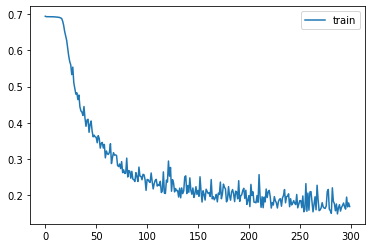

In [77]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 5
Number of indicators 3
              precision    recall  f1-score   support

           S    0.77455   1.00000   0.87295       560
           B    1.00000   0.62955   0.77266       440

    accuracy                        0.83700      1000
   macro avg    0.88728   0.81477   0.82281      1000
weighted avg    0.87375   0.83700   0.82883      1000

Confusion matrix, without normalization
[[560   0]
 [163 277]]


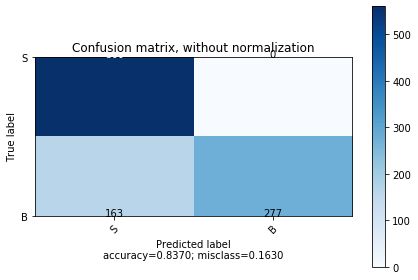

In [78]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 2s 384us/step - loss: 0.5634 - accuracy: 0.7072
Epoch 2/300
3996/3996 [==============================] - 1s 168us/step - loss: 0.5146 - accuracy: 0.7492
Epoch 3/300
3996/3996 [==============================] - 1s 181us/step - loss: 0.4820 - accuracy: 0.7813
Epoch 4/300
3996/3996 [==============================] - 1s 168us/step - loss: 0.4122 - accuracy: 0.8228
Epoch 5/300
3996/3996 [==============================] - 1s 171us/step - loss: 0.3246 - accuracy: 0.8676
Epoch 6/300
3996/3996 [==============================] - 1s 179us/step - loss: 0.2682 - accuracy: 0.8949
Epoch 7/300
3996/3996 [==============================] - 1s 183us/step - loss: 0.2348 - accuracy: 0.9119
Epoch 8/300
3996/3996 [==============================] - 1s 181us/step - loss: 0.2112 - accuracy: 0.9132
Epoch 9/300
3996/3996 [==============================] - 1s 176us/step - loss: 0.1827 - accuracy: 0.9299
Epoch 10/300
3996/3996 [==============================]

3996/3996 [==============================] - 1s 168us/step - loss: 0.0555 - accuracy: 0.9782
Epoch 79/300
3996/3996 [==============================] - 1s 164us/step - loss: 0.0563 - accuracy: 0.9767
Epoch 80/300
3996/3996 [==============================] - 1s 162us/step - loss: 0.0683 - accuracy: 0.9727
Epoch 81/300
3996/3996 [==============================] - 1s 166us/step - loss: 0.0440 - accuracy: 0.9862
Epoch 82/300
3996/3996 [==============================] - 1s 164us/step - loss: 0.0518 - accuracy: 0.9832
Epoch 83/300
3996/3996 [==============================] - 1s 163us/step - loss: 0.0508 - accuracy: 0.9835
Epoch 84/300
3996/3996 [==============================] - 1s 162us/step - loss: 0.0580 - accuracy: 0.9765
Epoch 85/300
3996/3996 [==============================] - 1s 161us/step - loss: 0.0516 - accuracy: 0.9852
Epoch 86/300
3996/3996 [==============================] - 1s 159us/step - loss: 0.0487 - accuracy: 0.9825
Epoch 87/300
3996/3996 [==============================] - 1

3996/3996 [==============================] - 1s 159us/step - loss: 0.0115 - accuracy: 0.9980
Epoch 231/300
3996/3996 [==============================] - 1s 158us/step - loss: 0.0078 - accuracy: 0.9992
Epoch 232/300
3996/3996 [==============================] - 1s 158us/step - loss: 0.0063 - accuracy: 0.9995
Epoch 233/300
3996/3996 [==============================] - 1s 158us/step - loss: 0.0095 - accuracy: 0.9985
Epoch 234/300
3996/3996 [==============================] - 1s 161us/step - loss: 0.0062 - accuracy: 0.9992
Epoch 235/300
3996/3996 [==============================] - 1s 162us/step - loss: 0.0091 - accuracy: 0.9975
Epoch 236/300
3996/3996 [==============================] - 1s 160us/step - loss: 0.0131 - accuracy: 0.9967
Epoch 237/300
3996/3996 [==============================] - 1s 169us/step - loss: 0.0212 - accuracy: 0.9945
Epoch 238/300
3996/3996 [==============================] - 1s 167us/step - loss: 0.0073 - accuracy: 0.9995
Epoch 239/300
3996/3996 [==========================

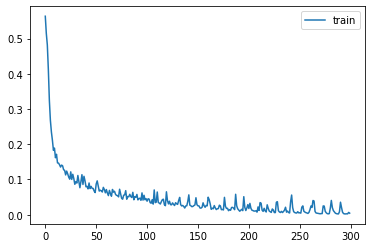

In [79]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 5
Number of indicators 6
              precision    recall  f1-score   support

           S    0.96328   0.79643   0.87195       560
           B    0.78771   0.96136   0.86592       440

    accuracy                        0.86900      1000
   macro avg    0.87550   0.87890   0.86893      1000
weighted avg    0.88603   0.86900   0.86929      1000

Confusion matrix, without normalization
[[446 114]
 [ 17 423]]


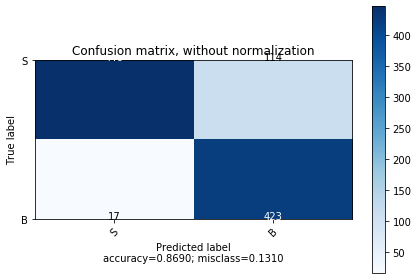

In [80]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 1s 356us/step - loss: 0.5474 - accuracy: 0.7265
Epoch 2/300
3996/3996 [==============================] - 1s 150us/step - loss: 0.4342 - accuracy: 0.8116
Epoch 3/300
3996/3996 [==============================] - 1s 168us/step - loss: 0.3649 - accuracy: 0.8526
Epoch 4/300
3996/3996 [==============================] - 1s 166us/step - loss: 0.3245 - accuracy: 0.8634
Epoch 5/300
3996/3996 [==============================] - 1s 165us/step - loss: 0.2937 - accuracy: 0.8746
Epoch 6/300
3996/3996 [==============================] - 1s 164us/step - loss: 0.2631 - accuracy: 0.8911
Epoch 7/300
3996/3996 [==============================] - 1s 165us/step - loss: 0.2433 - accuracy: 0.8966
Epoch 8/300
3996/3996 [==============================] - 1s 166us/step - loss: 0.2184 - accuracy: 0.9119
Epoch 9/300
3996/3996 [==============================] - 1s 165us/step - loss: 0.1949 - accuracy: 0.9212
Epoch 10/300
3996/3996 [==============================]

3996/3996 [==============================] - 1s 165us/step - loss: 0.0230 - accuracy: 0.9922
Epoch 155/300
3996/3996 [==============================] - 1s 161us/step - loss: 0.0257 - accuracy: 0.9920
Epoch 156/300
3996/3996 [==============================] - 1s 167us/step - loss: 0.0439 - accuracy: 0.9835
Epoch 157/300
3996/3996 [==============================] - 1s 160us/step - loss: 0.0399 - accuracy: 0.9857
Epoch 158/300
3996/3996 [==============================] - 1s 162us/step - loss: 0.0328 - accuracy: 0.9930
Epoch 159/300
3996/3996 [==============================] - 1s 163us/step - loss: 0.0266 - accuracy: 0.9927
Epoch 160/300
3996/3996 [==============================] - 1s 161us/step - loss: 0.0133 - accuracy: 0.9980
Epoch 161/300
3996/3996 [==============================] - 1s 159us/step - loss: 0.0140 - accuracy: 0.9977
Epoch 162/300
3996/3996 [==============================] - 1s 167us/step - loss: 0.0090 - accuracy: 0.9995
Epoch 163/300
3996/3996 [==========================

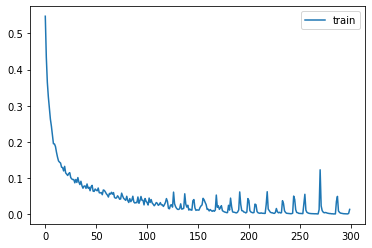

In [81]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 5
Number of indicators 8
              precision    recall  f1-score   support

           S    0.82549   0.97143   0.89253       560
           B    0.95308   0.73864   0.83227       440

    accuracy                        0.86900      1000
   macro avg    0.88929   0.85503   0.86240      1000
weighted avg    0.88163   0.86900   0.86602      1000

Confusion matrix, without normalization
[[544  16]
 [115 325]]


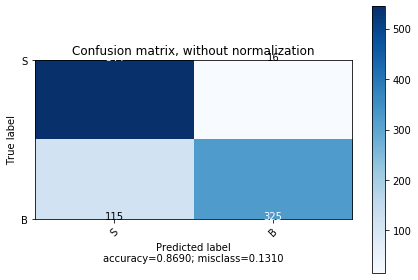

In [82]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 2s 477us/step - loss: 0.6943 - accuracy: 0.4995
Epoch 2/300
3992/3992 [==============================] - 1s 283us/step - loss: 0.6935 - accuracy: 0.4972
Epoch 3/300
3992/3992 [==============================] - 1s 284us/step - loss: 0.6934 - accuracy: 0.5010
Epoch 4/300
3992/3992 [==============================] - 1s 268us/step - loss: 0.6933 - accuracy: 0.5013
Epoch 5/300
3992/3992 [==============================] - 1s 269us/step - loss: 0.6932 - accuracy: 0.4927
Epoch 6/300
3992/3992 [==============================] - 1s 272us/step - loss: 0.6932 - accuracy: 0.4982
Epoch 7/300
3992/3992 [==============================] - 1s 270us/step - loss: 0.6932 - accuracy: 0.4987
Epoch 8/300
3992/3992 [==============================] - 1s 269us/step - loss: 0.6929 - accuracy: 0.5165
Epoch 9/300
3992/3992 [==============================] - 1s 271us/step - loss: 0.6929 - accuracy: 0.5070
Epoch 10/300
3992/3992 [==============================]

3992/3992 [==============================] - 1s 264us/step - loss: 0.2054 - accuracy: 0.9208
Epoch 155/300
3992/3992 [==============================] - 1s 264us/step - loss: 0.1750 - accuracy: 0.9406
Epoch 156/300
3992/3992 [==============================] - 1s 273us/step - loss: 0.1773 - accuracy: 0.9326
Epoch 157/300
3992/3992 [==============================] - 1s 273us/step - loss: 0.1753 - accuracy: 0.9316
Epoch 158/300
3992/3992 [==============================] - 1s 269us/step - loss: 0.1742 - accuracy: 0.9341
Epoch 159/300
3992/3992 [==============================] - 1s 264us/step - loss: 0.1800 - accuracy: 0.9241
Epoch 160/300
3992/3992 [==============================] - 1s 271us/step - loss: 0.2334 - accuracy: 0.9078
Epoch 161/300
3992/3992 [==============================] - 1s 272us/step - loss: 0.1791 - accuracy: 0.9304
Epoch 162/300
3992/3992 [==============================] - 1s 273us/step - loss: 0.1629 - accuracy: 0.9389
Epoch 163/300
3992/3992 [==========================

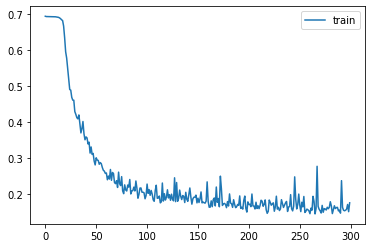

In [83]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 10
Number of indicators 3
              precision    recall  f1-score   support

           S    1.00000   0.77102   0.87071       559
           B    0.77465   1.00000   0.87302       440

    accuracy                        0.87187       999
   macro avg    0.88732   0.88551   0.87186       999
weighted avg    0.90075   0.87187   0.87172       999

Confusion matrix, without normalization
[[431 128]
 [  0 440]]


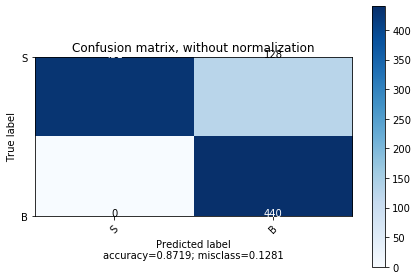

In [84]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 2s 481us/step - loss: 0.5867 - accuracy: 0.6946
Epoch 2/300
3992/3992 [==============================] - 1s 286us/step - loss: 0.5256 - accuracy: 0.7470
Epoch 3/300
3992/3992 [==============================] - 1s 279us/step - loss: 0.5044 - accuracy: 0.7570
Epoch 4/300
3992/3992 [==============================] - 1s 279us/step - loss: 0.4687 - accuracy: 0.7893
Epoch 5/300
3992/3992 [==============================] - 1s 278us/step - loss: 0.3965 - accuracy: 0.8327
Epoch 6/300
3992/3992 [==============================] - 1s 281us/step - loss: 0.3054 - accuracy: 0.8705
Epoch 7/300
3992/3992 [==============================] - 1s 293us/step - loss: 0.2688 - accuracy: 0.8923
Epoch 8/300
3992/3992 [==============================] - 1s 280us/step - loss: 0.2405 - accuracy: 0.9071
Epoch 9/300
3992/3992 [==============================] - 1s 293us/step - loss: 0.2076 - accuracy: 0.9216
Epoch 10/300
3992/3992 [==============================]

3992/3992 [==============================] - 1s 288us/step - loss: 0.0187 - accuracy: 0.9940
Epoch 155/300
3992/3992 [==============================] - 1s 324us/step - loss: 0.0116 - accuracy: 0.9985
Epoch 156/300
3992/3992 [==============================] - 1s 294us/step - loss: 0.0407 - accuracy: 0.9865
Epoch 157/300
3992/3992 [==============================] - 1s 362us/step - loss: 0.0181 - accuracy: 0.9960
Epoch 158/300
3992/3992 [==============================] - 1s 283us/step - loss: 0.0253 - accuracy: 0.9925
Epoch 159/300
3992/3992 [==============================] - 1s 274us/step - loss: 0.0318 - accuracy: 0.9912
Epoch 160/300
3992/3992 [==============================] - 1s 257us/step - loss: 0.0339 - accuracy: 0.9897
Epoch 161/300
3992/3992 [==============================] - 1s 255us/step - loss: 0.0285 - accuracy: 0.9932
Epoch 162/300
3992/3992 [==============================] - 1s 267us/step - loss: 0.0300 - accuracy: 0.9902
Epoch 163/300
3992/3992 [==========================

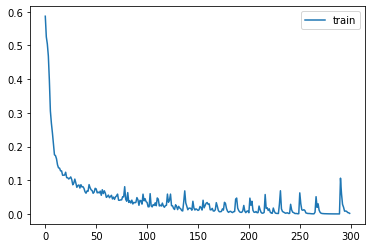

In [85]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 10
Number of indicators 6
              precision    recall  f1-score   support

           S    0.92281   0.94097   0.93180       559
           B    0.92308   0.90000   0.91139       440

    accuracy                        0.92292       999
   macro avg    0.92294   0.92048   0.92160       999
weighted avg    0.92293   0.92292   0.92281       999

Confusion matrix, without normalization
[[526  33]
 [ 44 396]]


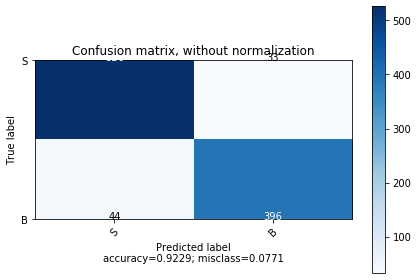

In [86]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 2s 463us/step - loss: 0.5675 - accuracy: 0.7132
Epoch 2/300
3992/3992 [==============================] - 1s 254us/step - loss: 0.4678 - accuracy: 0.7823
Epoch 3/300
3992/3992 [==============================] - 1s 257us/step - loss: 0.3903 - accuracy: 0.8377
Epoch 4/300
3992/3992 [==============================] - 1s 262us/step - loss: 0.3468 - accuracy: 0.8494
Epoch 5/300
3992/3992 [==============================] - 1s 257us/step - loss: 0.2977 - accuracy: 0.8773
Epoch 6/300
3992/3992 [==============================] - 1s 259us/step - loss: 0.2668 - accuracy: 0.8855
Epoch 7/300
3992/3992 [==============================] - 1s 269us/step - loss: 0.2342 - accuracy: 0.9046
Epoch 8/300
3992/3992 [==============================] - 1s 282us/step - loss: 0.2065 - accuracy: 0.9146
Epoch 9/300
3992/3992 [==============================] - 1s 311us/step - loss: 0.1941 - accuracy: 0.9233
Epoch 10/300
3992/3992 [==============================]

3992/3992 [==============================] - 1s 254us/step - loss: 0.0348 - accuracy: 0.9902
Epoch 155/300
3992/3992 [==============================] - 1s 255us/step - loss: 0.0150 - accuracy: 0.9965
Epoch 156/300
3992/3992 [==============================] - 1s 256us/step - loss: 0.0050 - accuracy: 0.9997
Epoch 157/300
3992/3992 [==============================] - 1s 255us/step - loss: 0.0235 - accuracy: 0.9905
Epoch 158/300
3992/3992 [==============================] - 1s 255us/step - loss: 0.0082 - accuracy: 0.9995
Epoch 159/300
3992/3992 [==============================] - 1s 255us/step - loss: 0.0049 - accuracy: 0.9995
Epoch 160/300
3992/3992 [==============================] - 1s 257us/step - loss: 0.0049 - accuracy: 0.9992
Epoch 161/300
3992/3992 [==============================] - 1s 256us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 162/300
3992/3992 [==============================] - 1s 256us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 163/300
3992/3992 [==========================

Epoch 230/300
3992/3992 [==============================] - 1s 314us/step - loss: 0.0356 - accuracy: 0.9875
Epoch 231/300
3992/3992 [==============================] - 1s 288us/step - loss: 0.0075 - accuracy: 0.9997
Epoch 232/300
3992/3992 [==============================] - 1s 270us/step - loss: 0.0032 - accuracy: 1.0000
Epoch 233/300
3992/3992 [==============================] - 1s 276us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 234/300
3992/3992 [==============================] - 1s 270us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 235/300
3992/3992 [==============================] - 1s 268us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 236/300
3992/3992 [==============================] - 1s 268us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 237/300
3992/3992 [==============================] - 1s 267us/step - loss: 7.7235e-04 - accuracy: 1.0000
Epoch 238/300
3992/3992 [==============================] - 1s 268us/step - loss: 6.3088e-04 - accuracy: 1.0000
Epoch 239/300
3992/3992 [====

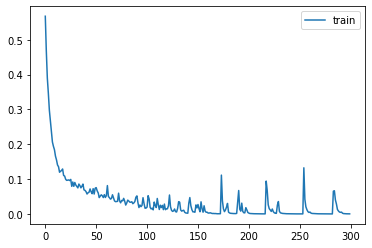

In [87]:
fit(m, c, s, i)

Model lstm
Number of classes 2
Number of steps 10
Number of indicators 8
              precision    recall  f1-score   support

           S    0.93217   0.86047   0.89488       559
           B    0.83851   0.92045   0.87757       440

    accuracy                        0.88689       999
   macro avg    0.88534   0.89046   0.88623       999
weighted avg    0.89092   0.88689   0.88726       999

Confusion matrix, without normalization
[[481  78]
 [ 35 405]]


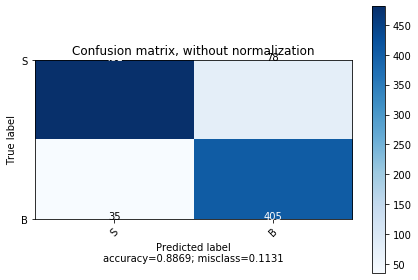

In [88]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 1s 286us/step - loss: 2.0736 - accuracy: 0.1435
Epoch 2/300
3999/3999 [==============================] - 0s 87us/step - loss: 2.0693 - accuracy: 0.1518
Epoch 3/300
3999/3999 [==============================] - 0s 101us/step - loss: 2.0683 - accuracy: 0.1498
Epoch 4/300
3999/3999 [==============================] - 0s 98us/step - loss: 2.0676 - accuracy: 0.1505
Epoch 5/300
3999/3999 [==============================] - 0s 100us/step - loss: 2.0662 - accuracy: 0.1525
Epoch 6/300
3999/3999 [==============================] - 0s 99us/step - loss: 2.0650 - accuracy: 0.1560
Epoch 7/300
3999/3999 [==============================] - 0s 104us/step - loss: 2.0628 - accuracy: 0.1545
Epoch 8/300
3999/3999 [==============================] - 0s 104us/step - loss: 2.0609 - accuracy: 0.1608
Epoch 9/300
3999/3999 [==============================] - 0s 101us/step - loss: 2.0596 - accuracy: 0.1605
Epoch 10/300
3999/3999 [==============================] - 

3999/3999 [==============================] - 0s 99us/step - loss: 1.0783 - accuracy: 0.6367
Epoch 156/300
3999/3999 [==============================] - 0s 98us/step - loss: 1.0791 - accuracy: 0.6254
Epoch 157/300
3999/3999 [==============================] - 0s 99us/step - loss: 1.0785 - accuracy: 0.6302
Epoch 158/300
3999/3999 [==============================] - 0s 99us/step - loss: 1.0736 - accuracy: 0.6329
Epoch 159/300
3999/3999 [==============================] - 0s 98us/step - loss: 1.0693 - accuracy: 0.6322
Epoch 160/300
3999/3999 [==============================] - 0s 100us/step - loss: 1.0656 - accuracy: 0.6282
Epoch 161/300
3999/3999 [==============================] - 0s 99us/step - loss: 1.0597 - accuracy: 0.6259
Epoch 162/300
3999/3999 [==============================] - 0s 99us/step - loss: 1.0583 - accuracy: 0.6362
Epoch 163/300
3999/3999 [==============================] - 0s 99us/step - loss: 1.0496 - accuracy: 0.6527
Epoch 164/300
3999/3999 [==============================] - 

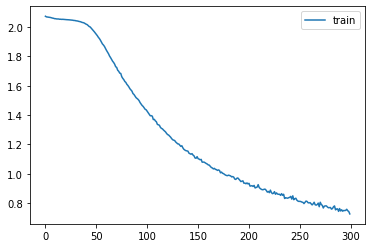

In [89]:
fit(m, c, s, i)

Model lstm
Number of classes 8
Number of steps 2
Number of indicators 3
              precision    recall  f1-score   support

          B3    0.89474   1.00000   0.94444        51
          B2    0.97531   0.80612   0.88268        98
          B1    0.00000   0.00000   0.00000       118
          B0    1.00000   0.00578   0.01149       173
          S0    0.00000   0.00000   0.00000       220
          S1    0.75000   0.02206   0.04286       136
          S2    0.83333   0.78767   0.80986       146
          S3    1.00000   0.58621   0.73913        58

   micro avg    0.89841   0.28300   0.43042      1000
   macro avg    0.68167   0.40098   0.42881      1000
weighted avg    0.59588   0.28300   0.30360      1000
 samples avg    0.28300   0.28300   0.28300      1000

Confusion matrix, without normalization
[[ 51   0   0   0   0   0   0   0]
 [ 19  79   0   0   0   0   0   0]
 [116   2   0   0   0   0   0   0]
 [172   0   0   1   0   0   0   0]
 [220   0   0   0   0   0   0   0]
 [133   

/Users/kisdev/anaconda3/envs/mc030/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kisdev/anaconda3/envs/mc030/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


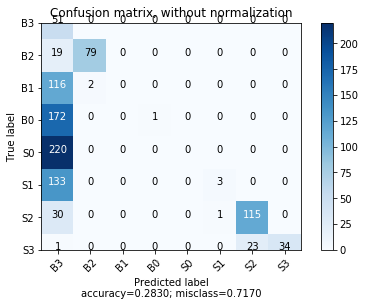

In [90]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 1s 309us/step - loss: 1.9531 - accuracy: 0.2078
Epoch 2/300
3999/3999 [==============================] - 0s 98us/step - loss: 1.8654 - accuracy: 0.2448
Epoch 3/300
3999/3999 [==============================] - 0s 102us/step - loss: 1.8218 - accuracy: 0.2598
Epoch 4/300
3999/3999 [==============================] - 0s 102us/step - loss: 1.7914 - accuracy: 0.2793
Epoch 5/300
3999/3999 [==============================] - 0s 102us/step - loss: 1.7514 - accuracy: 0.3011
Epoch 6/300
3999/3999 [==============================] - 0s 100us/step - loss: 1.6855 - accuracy: 0.3053
Epoch 7/300
3999/3999 [==============================] - 0s 100us/step - loss: 1.5911 - accuracy: 0.3468
Epoch 8/300
3999/3999 [==============================] - 0s 102us/step - loss: 1.4933 - accuracy: 0.3953
Epoch 9/300
3999/3999 [==============================] - 0s 100us/step - loss: 1.4014 - accuracy: 0.4276
Epoch 10/300
3999/3999 [==============================] 

3999/3999 [==============================] - 0s 98us/step - loss: 0.7707 - accuracy: 0.6807
Epoch 156/300
3999/3999 [==============================] - 0s 99us/step - loss: 0.7689 - accuracy: 0.6749
Epoch 157/300
3999/3999 [==============================] - 0s 100us/step - loss: 0.7782 - accuracy: 0.6784
Epoch 158/300
3999/3999 [==============================] - 0s 99us/step - loss: 0.7725 - accuracy: 0.6847
Epoch 159/300
3999/3999 [==============================] - 0s 99us/step - loss: 0.7754 - accuracy: 0.6764
Epoch 160/300
3999/3999 [==============================] - 0s 99us/step - loss: 0.7716 - accuracy: 0.6769
Epoch 161/300
3999/3999 [==============================] - 0s 99us/step - loss: 0.7678 - accuracy: 0.6882
Epoch 162/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.7569 - accuracy: 0.6907
Epoch 163/300
3999/3999 [==============================] - 0s 100us/step - loss: 0.7585 - accuracy: 0.6817
Epoch 164/300
3999/3999 [==============================] -

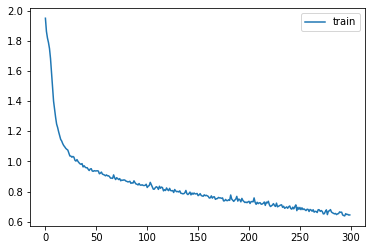

In [91]:
fit(m, c, s, i)

Model lstm
Number of classes 8
Number of steps 2
Number of indicators 6
              precision    recall  f1-score   support

          B3    0.51685   0.90196   0.65714        51
          B2    0.32530   0.55102   0.40909        98
          B1    0.00000   0.00000   0.00000       118
          B0    0.61585   0.58382   0.59941       173
          S0    0.93333   0.12727   0.22400       220
          S1    0.36842   0.05147   0.09032       136
          S2    0.56667   0.46575   0.51128       146
          S3    0.58065   0.62069   0.60000        58

   micro avg    0.52308   0.34000   0.41212      1000
   macro avg    0.48838   0.41275   0.38641      1000
weighted avg    0.53663   0.34000   0.34831      1000
 samples avg    0.34000   0.34000   0.34000      1000

Confusion matrix, without normalization
[[ 48   3   0   0   0   0   0   0]
 [ 43  54   0   1   0   0   0   0]
 [ 25  81   0  12   0   0   0   0]
 [ 44  28   0 101   0   0   0   0]
 [128   0   0  50  28  11   3   0]
 [ 91   

/Users/kisdev/anaconda3/envs/mc030/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kisdev/anaconda3/envs/mc030/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


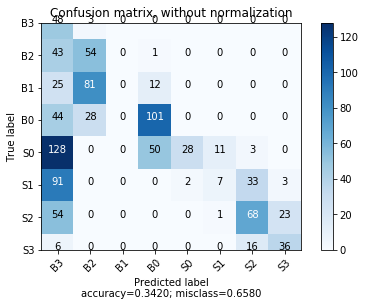

In [92]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3999/3999 [==============================] - 1s 362us/step - loss: 1.9325 - accuracy: 0.2118
Epoch 2/300
3999/3999 [==============================] - 0s 101us/step - loss: 1.8195 - accuracy: 0.2673
Epoch 3/300
3999/3999 [==============================] - 0s 103us/step - loss: 1.7349 - accuracy: 0.2913
Epoch 4/300
3999/3999 [==============================] - 0s 101us/step - loss: 1.6620 - accuracy: 0.3206
Epoch 5/300
3999/3999 [==============================] - 0s 99us/step - loss: 1.5952 - accuracy: 0.3478
Epoch 6/300
3999/3999 [==============================] - 0s 100us/step - loss: 1.5270 - accuracy: 0.3631
Epoch 7/300
3999/3999 [==============================] - 0s 101us/step - loss: 1.4676 - accuracy: 0.3998
Epoch 8/300
3999/3999 [==============================] - 0s 98us/step - loss: 1.4157 - accuracy: 0.4091
Epoch 9/300
3999/3999 [==============================] - 0s 98us/step - loss: 1.3690 - accuracy: 0.4281
Epoch 10/300
3999/3999 [==============================] - 

3999/3999 [==============================] - 0s 97us/step - loss: 0.6937 - accuracy: 0.7152
Epoch 156/300
3999/3999 [==============================] - 0s 107us/step - loss: 0.6906 - accuracy: 0.7184
Epoch 157/300
3999/3999 [==============================] - 0s 99us/step - loss: 0.6769 - accuracy: 0.7257
Epoch 158/300
3999/3999 [==============================] - 0s 101us/step - loss: 0.6661 - accuracy: 0.7322
Epoch 159/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.6861 - accuracy: 0.7144
Epoch 160/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.6691 - accuracy: 0.7344
Epoch 161/300
3999/3999 [==============================] - 0s 99us/step - loss: 0.6617 - accuracy: 0.7339
Epoch 162/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.6734 - accuracy: 0.7247
Epoch 163/300
3999/3999 [==============================] - 0s 98us/step - loss: 0.6771 - accuracy: 0.7229
Epoch 164/300
3999/3999 [==============================] -

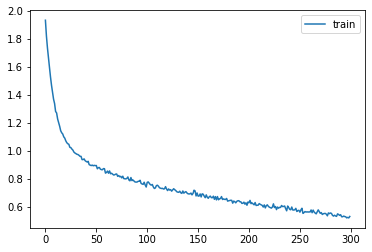

In [93]:
fit(m, c, s, i)

Model lstm
Number of classes 8
Number of steps 2
Number of indicators 8
              precision    recall  f1-score   support

          B3    0.47115   0.96078   0.63226        51
          B2    0.30894   0.38776   0.34389        98
          B1    0.26190   0.09322   0.13750       118
          B0    0.79268   0.37572   0.50980       173
          S0    0.81013   0.29091   0.42809       220
          S1    0.31818   0.05147   0.08861       136
          S2    0.42735   0.34247   0.38023       146
          S3    0.23618   0.81034   0.36576        58

   micro avg    0.43099   0.33100   0.37443      1000
   macro avg    0.45332   0.41408   0.36077      1000
weighted avg    0.51994   0.33100   0.35333      1000
 samples avg    0.33100   0.33100   0.33100      1000

Confusion matrix, without normalization
[[51  0  0  0  0  0  0  0]
 [58 38  2  0  0  0  0  0]
 [34 66 11  7  0  0  0  0]
 [52 19 29 65  8  0  0  0]
 [93  0  0 10 64 13 18 22]
 [38  0  0  0  7  7 38 46]
 [10  0  0  0  0  2 5

/Users/kisdev/anaconda3/envs/mc030/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


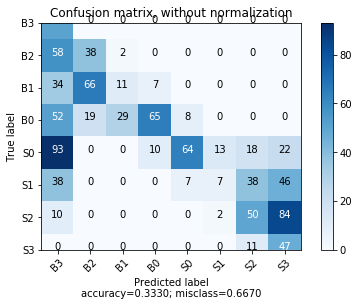

In [94]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 1s 347us/step - loss: 2.0745 - accuracy: 0.1431
Epoch 2/300
3996/3996 [==============================] - 1s 164us/step - loss: 2.0694 - accuracy: 0.1547
Epoch 3/300
3996/3996 [==============================] - 1s 166us/step - loss: 2.0688 - accuracy: 0.1486
Epoch 4/300
3996/3996 [==============================] - 1s 167us/step - loss: 2.0668 - accuracy: 0.1517
Epoch 5/300
3996/3996 [==============================] - 1s 165us/step - loss: 2.0643 - accuracy: 0.1542
Epoch 6/300
3996/3996 [==============================] - 1s 164us/step - loss: 2.0609 - accuracy: 0.1549
Epoch 7/300
3996/3996 [==============================] - 1s 165us/step - loss: 2.0575 - accuracy: 0.1572
Epoch 8/300
3996/3996 [==============================] - 1s 164us/step - loss: 2.0560 - accuracy: 0.1692
Epoch 9/300
3996/3996 [==============================] - 1s 165us/step - loss: 2.0551 - accuracy: 0.1649
Epoch 10/300
3996/3996 [==============================]

3996/3996 [==============================] - 1s 162us/step - loss: 0.8707 - accuracy: 0.6051
Epoch 155/300
3996/3996 [==============================] - 1s 162us/step - loss: 0.9783 - accuracy: 0.5501
Epoch 156/300
3996/3996 [==============================] - 1s 164us/step - loss: 0.8104 - accuracy: 0.6622
Epoch 157/300
3996/3996 [==============================] - 1s 164us/step - loss: 0.7808 - accuracy: 0.7065
Epoch 158/300
3996/3996 [==============================] - 1s 162us/step - loss: 0.8219 - accuracy: 0.6494
Epoch 159/300
3996/3996 [==============================] - 1s 161us/step - loss: 0.8612 - accuracy: 0.6466
Epoch 160/300
3996/3996 [==============================] - 1s 162us/step - loss: 0.8554 - accuracy: 0.6146
Epoch 161/300
3996/3996 [==============================] - 1s 161us/step - loss: 0.8174 - accuracy: 0.6627
Epoch 162/300
3996/3996 [==============================] - 1s 162us/step - loss: 0.7857 - accuracy: 0.6887
Epoch 163/300
3996/3996 [==========================

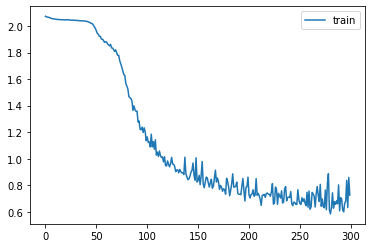

In [95]:
fit(m, c, s, i)

Model lstm
Number of classes 8
Number of steps 5
Number of indicators 3
              precision    recall  f1-score   support

          B3    0.68000   1.00000   0.80952        51
          B2    0.57364   0.75510   0.65198        98
          B1    0.47273   0.22034   0.30058       118
          B0    0.40081   0.57225   0.47143       173
          S0    0.33333   0.10909   0.16438       220
          S1    0.36066   0.16176   0.22335       136
          S2    0.79487   0.63699   0.70722       146
          S3    1.00000   0.58621   0.73913        58

   micro avg    0.53544   0.42300   0.47263      1000
   macro avg    0.57701   0.50522   0.50845      1000
weighted avg    0.51245   0.42300   0.43487      1000
 samples avg    0.42300   0.42300   0.42300      1000

Confusion matrix, without normalization
[[ 51   0   0   0   0   0   0   0]
 [ 24  74   0   0   0   0   0   0]
 [ 37  55  26   0   0   0   0   0]
 [ 45   0  29  99   0   0   0   0]
 [ 48   0   0 148  24   0   0   0]
 [ 66   

/Users/kisdev/anaconda3/envs/mc030/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


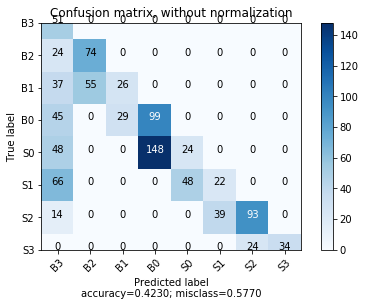

In [96]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 1s 346us/step - loss: 1.9194 - accuracy: 0.2130
Epoch 2/300
3996/3996 [==============================] - 1s 164us/step - loss: 1.7876 - accuracy: 0.2678
Epoch 3/300
3996/3996 [==============================] - 1s 164us/step - loss: 1.7537 - accuracy: 0.2770
Epoch 4/300
3996/3996 [==============================] - 1s 164us/step - loss: 1.7250 - accuracy: 0.2968
Epoch 5/300
3996/3996 [==============================] - 1s 164us/step - loss: 1.6713 - accuracy: 0.3076
Epoch 6/300
3996/3996 [==============================] - 1s 164us/step - loss: 1.5920 - accuracy: 0.3346
Epoch 7/300
3996/3996 [==============================] - 1s 163us/step - loss: 1.4923 - accuracy: 0.3674
Epoch 8/300
3996/3996 [==============================] - 1s 163us/step - loss: 1.4182 - accuracy: 0.3879
Epoch 9/300
3996/3996 [==============================] - 1s 162us/step - loss: 1.3402 - accuracy: 0.4089
Epoch 10/300
3996/3996 [==============================]

3996/3996 [==============================] - 1s 156us/step - loss: 0.4119 - accuracy: 0.8318
Epoch 155/300
3996/3996 [==============================] - 1s 157us/step - loss: 0.4469 - accuracy: 0.8178
Epoch 156/300
3996/3996 [==============================] - 1s 160us/step - loss: 0.4346 - accuracy: 0.8281
Epoch 157/300
3996/3996 [==============================] - 1s 157us/step - loss: 0.4377 - accuracy: 0.8298
Epoch 158/300
3996/3996 [==============================] - 1s 159us/step - loss: 0.4413 - accuracy: 0.8338
Epoch 159/300
3996/3996 [==============================] - 1s 163us/step - loss: 0.4057 - accuracy: 0.8401
Epoch 160/300
3996/3996 [==============================] - 1s 158us/step - loss: 0.3914 - accuracy: 0.8514
Epoch 161/300
3996/3996 [==============================] - 1s 157us/step - loss: 0.3779 - accuracy: 0.8539
Epoch 162/300
3996/3996 [==============================] - 1s 157us/step - loss: 0.3864 - accuracy: 0.8386
Epoch 163/300
3996/3996 [==========================

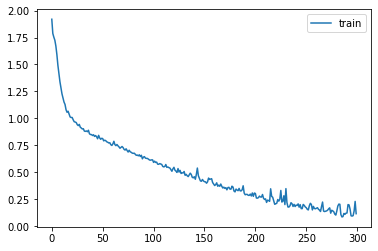

In [97]:
fit(m, c, s, i)

Model lstm
Number of classes 8
Number of steps 5
Number of indicators 6
              precision    recall  f1-score   support

          B3    0.28481   0.88235   0.43062        51
          B2    0.24576   0.29592   0.26852        98
          B1    0.27273   0.15254   0.19565       118
          B0    0.42727   0.27168   0.33216       173
          S0    0.65517   0.25909   0.37134       220
          S1    0.34416   0.38971   0.36552       136
          S2    0.50588   0.29452   0.37229       146
          S3    0.30201   0.77586   0.43478        58

   micro avg    0.36354   0.33700   0.34977      1000
   macro avg    0.37972   0.41521   0.34636      1000
weighted avg    0.42703   0.33700   0.33980      1000
 samples avg    0.33700   0.33700   0.33700      1000

Confusion matrix, without normalization
[[46  5  0  0  0  0  0  0]
 [63 29  4  2  0  0  0  0]
 [54 39 18  5  2  0  0  0]
 [34 45 33 47 12  1  1  0]
 [21  0 11 48 57 65  9  9]
 [ 8  0  0  8 14 53 22 31]
 [ 5  0  0  0  2 32 4

/Users/kisdev/anaconda3/envs/mc030/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


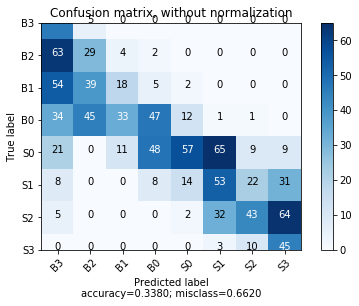

In [98]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3996/3996 [==============================] - 1s 350us/step - loss: 1.9302 - accuracy: 0.2082
Epoch 2/300
3996/3996 [==============================] - 1s 176us/step - loss: 1.7716 - accuracy: 0.2765
Epoch 3/300
3996/3996 [==============================] - 1s 166us/step - loss: 1.6821 - accuracy: 0.3056
Epoch 4/300
3996/3996 [==============================] - 1s 166us/step - loss: 1.6040 - accuracy: 0.3291
Epoch 5/300
3996/3996 [==============================] - 1s 163us/step - loss: 1.5374 - accuracy: 0.3483
Epoch 6/300
3996/3996 [==============================] - 1s 161us/step - loss: 1.4880 - accuracy: 0.3756
Epoch 7/300
3996/3996 [==============================] - 1s 162us/step - loss: 1.4334 - accuracy: 0.3914
Epoch 8/300
3996/3996 [==============================] - 1s 163us/step - loss: 1.3951 - accuracy: 0.4082
Epoch 9/300
3996/3996 [==============================] - 1s 164us/step - loss: 1.3585 - accuracy: 0.4292
Epoch 10/300
3996/3996 [==============================]

3996/3996 [==============================] - 1s 161us/step - loss: 0.2696 - accuracy: 0.9044
Epoch 155/300
3996/3996 [==============================] - 1s 170us/step - loss: 0.2379 - accuracy: 0.9167
Epoch 156/300
3996/3996 [==============================] - 1s 166us/step - loss: 0.2496 - accuracy: 0.9074
Epoch 157/300
3996/3996 [==============================] - 1s 161us/step - loss: 0.2624 - accuracy: 0.9039
Epoch 158/300
3996/3996 [==============================] - 1s 166us/step - loss: 0.2261 - accuracy: 0.9179
Epoch 159/300
3996/3996 [==============================] - 1s 192us/step - loss: 0.2508 - accuracy: 0.9099
Epoch 160/300
3996/3996 [==============================] - 1s 177us/step - loss: 0.2747 - accuracy: 0.9034
Epoch 161/300
3996/3996 [==============================] - 1s 199us/step - loss: 0.2943 - accuracy: 0.8839
Epoch 162/300
3996/3996 [==============================] - 1s 198us/step - loss: 0.2113 - accuracy: 0.9269
Epoch 163/300
3996/3996 [==========================

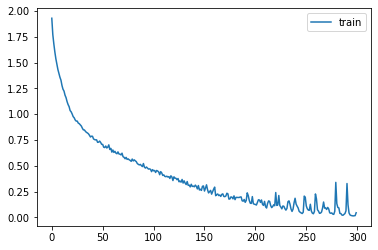

In [99]:
fit(m, c, s, i)

Model lstm
Number of classes 8
Number of steps 5
Number of indicators 8
              precision    recall  f1-score   support

          B3    0.17391   0.94118   0.29358        51
          B2    0.21538   0.14286   0.17178        98
          B1    0.27083   0.11017   0.15663       118
          B0    0.37500   0.38150   0.37822       173
          S0    0.73134   0.22273   0.34146       220
          S1    0.47727   0.30882   0.37500       136
          S2    0.45238   0.26027   0.33043       146
          S3    0.29341   0.84483   0.43556        58

   micro avg    0.32853   0.31900   0.32369      1000
   macro avg    0.37369   0.40154   0.31033      1000
weighted avg    0.43568   0.31900   0.31535      1000
 samples avg    0.31900   0.31900   0.31900      1000

Confusion matrix, without normalization
[[48  3  0  0  0  0  0  0]
 [80 14  3  1  0  0  0  0]
 [73 25 13  7  0  0  0  0]
 [51 22 27 66  6  0  1  0]
 [34  1  4 88 49 23 13  8]
 [14  0  1 13 11 42 24 31]
 [ 5  0  0  1  1 22 3

/Users/kisdev/anaconda3/envs/mc030/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


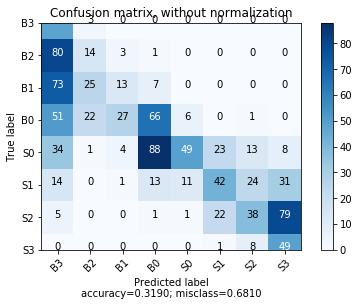

In [100]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 2s 554us/step - loss: 2.0730 - accuracy: 0.1423
Epoch 2/300
3992/3992 [==============================] - 1s 272us/step - loss: 2.0693 - accuracy: 0.1488
Epoch 3/300
3992/3992 [==============================] - 1s 260us/step - loss: 2.0680 - accuracy: 0.1438
Epoch 4/300
3992/3992 [==============================] - 1s 264us/step - loss: 2.0652 - accuracy: 0.1553
Epoch 5/300
3992/3992 [==============================] - 1s 267us/step - loss: 2.0605 - accuracy: 0.1593
Epoch 6/300
3992/3992 [==============================] - 1s 264us/step - loss: 2.0580 - accuracy: 0.1566
Epoch 7/300
3992/3992 [==============================] - 1s 262us/step - loss: 2.0546 - accuracy: 0.1691
Epoch 8/300
3992/3992 [==============================] - 1s 260us/step - loss: 2.0539 - accuracy: 0.1616
Epoch 9/300
3992/3992 [==============================] - 1s 267us/step - loss: 2.0527 - accuracy: 0.1661
Epoch 10/300
3992/3992 [==============================]

3992/3992 [==============================] - 1s 325us/step - loss: 1.1813 - accuracy: 0.4935
Epoch 155/300
3992/3992 [==============================] - 1s 295us/step - loss: 1.1351 - accuracy: 0.5093
Epoch 156/300
3992/3992 [==============================] - 1s 299us/step - loss: 1.1503 - accuracy: 0.4935
Epoch 157/300
3992/3992 [==============================] - 1s 286us/step - loss: 1.0561 - accuracy: 0.5431
Epoch 158/300
3992/3992 [==============================] - 1s 273us/step - loss: 1.1062 - accuracy: 0.5090
Epoch 159/300
3992/3992 [==============================] - 1s 271us/step - loss: 1.1009 - accuracy: 0.5261
Epoch 160/300
3992/3992 [==============================] - 1s 260us/step - loss: 1.0172 - accuracy: 0.5789
Epoch 161/300
3992/3992 [==============================] - 1s 263us/step - loss: 0.9840 - accuracy: 0.5877
Epoch 162/300
3992/3992 [==============================] - 1s 267us/step - loss: 1.1350 - accuracy: 0.5311
Epoch 163/300
3992/3992 [==========================

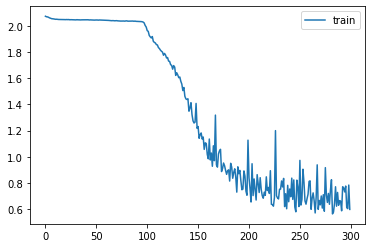

In [101]:
fit(m, c, s, i)

Model lstm
Number of classes 8
Number of steps 10
Number of indicators 3
              precision    recall  f1-score   support

          B3    1.00000   0.92157   0.95918        51
          B2    0.94667   0.72449   0.82081        98
          B1    0.77586   0.76271   0.76923       118
          B0    0.88095   0.64162   0.74247       173
          S0    0.83333   0.91324   0.87146       219
          S1    0.89510   0.94118   0.91756       136
          S2    0.97600   0.83562   0.90037       146
          S3    0.80556   1.00000   0.89231        58

   micro avg    0.87606   0.82783   0.85126       999
   macro avg    0.88918   0.84255   0.85917       999
weighted avg    0.88206   0.82783   0.84827       999
 samples avg    0.82783   0.82783   0.82783       999

Confusion matrix, without normalization
[[ 47   4   0   0   0   0   0   0]
 [  1  71  26   0   0   0   0   0]
 [ 13   0  90  15   0   0   0   0]
 [ 23   0   0 111  39   0   0   0]
 [ 13   0   0   0 200   6   0   0]
 [  4  

/Users/kisdev/anaconda3/envs/mc030/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


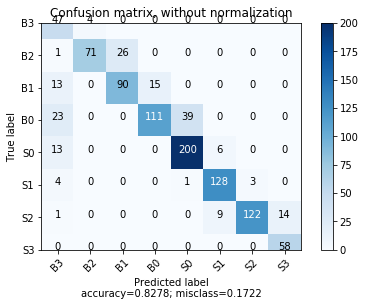

In [102]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 2s 471us/step - loss: 1.9349 - accuracy: 0.2124
Epoch 2/300
3992/3992 [==============================] - 1s 284us/step - loss: 1.7981 - accuracy: 0.2555
Epoch 3/300
3992/3992 [==============================] - 1s 278us/step - loss: 1.7615 - accuracy: 0.2690
Epoch 4/300
3992/3992 [==============================] - 1s 273us/step - loss: 1.7446 - accuracy: 0.2806
Epoch 5/300
3992/3992 [==============================] - 1s 283us/step - loss: 1.7259 - accuracy: 0.2928
Epoch 6/300
3992/3992 [==============================] - 1s 282us/step - loss: 1.7018 - accuracy: 0.3004
Epoch 7/300
3992/3992 [==============================] - 1s 281us/step - loss: 1.6438 - accuracy: 0.3244
Epoch 8/300
3992/3992 [==============================] - 1s 278us/step - loss: 1.5480 - accuracy: 0.3532
Epoch 9/300
3992/3992 [==============================] - 1s 288us/step - loss: 1.4636 - accuracy: 0.3788
Epoch 10/300
3992/3992 [==============================]

3992/3992 [==============================] - 1s 323us/step - loss: 0.2360 - accuracy: 0.9193
Epoch 155/300
3992/3992 [==============================] - 1s 298us/step - loss: 0.2518 - accuracy: 0.9146
Epoch 156/300
3992/3992 [==============================] - 1s 291us/step - loss: 0.1906 - accuracy: 0.9376
Epoch 157/300
3992/3992 [==============================] - 2s 417us/step - loss: 0.1653 - accuracy: 0.9476
Epoch 158/300
3992/3992 [==============================] - 1s 303us/step - loss: 0.1790 - accuracy: 0.9396
Epoch 159/300
3992/3992 [==============================] - 1s 285us/step - loss: 0.2133 - accuracy: 0.9223
Epoch 160/300
3992/3992 [==============================] - 1s 296us/step - loss: 0.2422 - accuracy: 0.9136
Epoch 161/300
3992/3992 [==============================] - 1s 295us/step - loss: 0.1530 - accuracy: 0.9529
Epoch 162/300
3992/3992 [==============================] - 1s 293us/step - loss: 0.1404 - accuracy: 0.9539
Epoch 163/300
3992/3992 [==========================

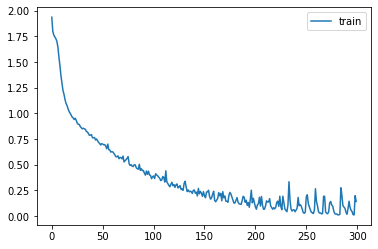

In [103]:
fit(m, c, s, i)

Model lstm
Number of classes 8
Number of steps 10
Number of indicators 6
              precision    recall  f1-score   support

          B3    0.29508   0.70588   0.41618        51
          B2    0.35537   0.43878   0.39269        98
          B1    0.22785   0.15254   0.18274       118
          B0    0.40331   0.42197   0.41243       173
          S0    0.55224   0.16895   0.25874       219
          S1    0.34711   0.30882   0.32685       136
          S2    0.34932   0.34932   0.34932       146
          S3    0.23636   0.44828   0.30952        58

   micro avg    0.34424   0.32633   0.33505       999
   macro avg    0.34583   0.37432   0.33106       999
weighted avg    0.37977   0.32633   0.32301       999
 samples avg    0.32633   0.32633   0.32633       999

Confusion matrix, without normalization
[[36 14  0  1  0  0  0  0]
 [45 43  9  1  0  0  0  0]
 [42 38 18 19  1  0  0  0]
 [18 23 44 73  9  5  1  0]
 [24  3  7 62 37 48 27 11]
 [ 3  0  1 22 14 42 39 15]
 [ 5  0  0  2  6 24 

/Users/kisdev/anaconda3/envs/mc030/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


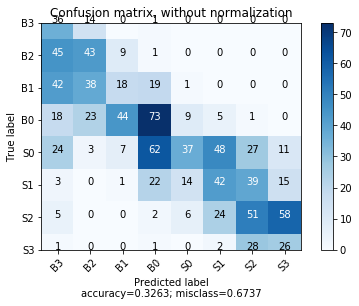

In [104]:
predict(m, c, s, i)
m, c, s, i = get_next_value(m, c, s, i)

Epoch 1/300
3992/3992 [==============================] - 2s 451us/step - loss: 1.9198 - accuracy: 0.2167
Epoch 2/300
3992/3992 [==============================] - 1s 270us/step - loss: 1.7947 - accuracy: 0.2598
Epoch 3/300
3992/3992 [==============================] - 1s 281us/step - loss: 1.7189 - accuracy: 0.2923
Epoch 4/300
3992/3992 [==============================] - 1s 283us/step - loss: 1.6239 - accuracy: 0.3176
Epoch 5/300
3992/3992 [==============================] - 1s 290us/step - loss: 1.5500 - accuracy: 0.3392
Epoch 6/300
3992/3992 [==============================] - 1s 296us/step - loss: 1.4910 - accuracy: 0.3730
Epoch 7/300
3992/3992 [==============================] - 1s 276us/step - loss: 1.4436 - accuracy: 0.3868
Epoch 8/300
3992/3992 [==============================] - 1s 273us/step - loss: 1.3968 - accuracy: 0.4121
Epoch 9/300
3992/3992 [==============================] - 1s 271us/step - loss: 1.3299 - accuracy: 0.4334
Epoch 10/300
3992/3992 [==============================]

3992/3992 [==============================] - 1s 276us/step - loss: 0.1670 - accuracy: 0.9421
Epoch 155/300
3992/3992 [==============================] - 1s 272us/step - loss: 0.1477 - accuracy: 0.9507
Epoch 156/300
3992/3992 [==============================] - 1s 269us/step - loss: 0.1567 - accuracy: 0.9461
Epoch 157/300
3992/3992 [==============================] - 1s 268us/step - loss: 0.1744 - accuracy: 0.9414
Epoch 158/300
3992/3992 [==============================] - 1s 277us/step - loss: 0.1400 - accuracy: 0.9539
Epoch 159/300
3992/3992 [==============================] - 1s 280us/step - loss: 0.1885 - accuracy: 0.9364
Epoch 160/300
3992/3992 [==============================] - 1s 273us/step - loss: 0.1751 - accuracy: 0.9426
Epoch 161/300
3992/3992 [==============================] - 1s 269us/step - loss: 0.1541 - accuracy: 0.9504
Epoch 162/300
3992/3992 [==============================] - 1s 268us/step - loss: 0.1641 - accuracy: 0.9459
Epoch 163/300
3992/3992 [==========================

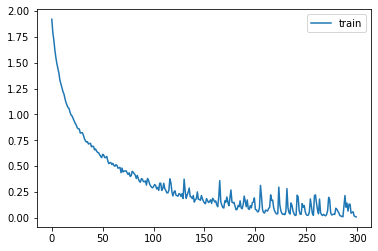

In [105]:
fit(m, c, s, i)

Model lstm
Number of classes 8
Number of steps 10
Number of indicators 8
              precision    recall  f1-score   support

          B3    0.40385   0.82353   0.54194        51
          B2    0.29012   0.47959   0.36154        98
          B1    0.32394   0.19492   0.24339       118
          B0    0.44737   0.39306   0.41846       173
          S0    0.60526   0.21005   0.31186       219
          S1    0.24138   0.15441   0.18834       136
          S2    0.34868   0.36301   0.35570       146
          S3    0.27586   0.68966   0.39409        58

   micro avg    0.35827   0.34034   0.34908       999
   macro avg    0.36706   0.41353   0.35192       999
weighted avg    0.39733   0.34034   0.33322       999
 samples avg    0.34034   0.34034   0.34034       999

Confusion matrix, without normalization
[[42  9  0  0  0  0  0  0]
 [43 47  6  2  0  0  0  0]
 [23 62 23 10  0  0  0  0]
 [14 41 35 68 10  5  0  0]
 [19  3  7 58 46 45 31 10]
 [10  0  0 13 18 21 50 24]
 [ 3  0  0  1  2 16 

/Users/kisdev/anaconda3/envs/mc030/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


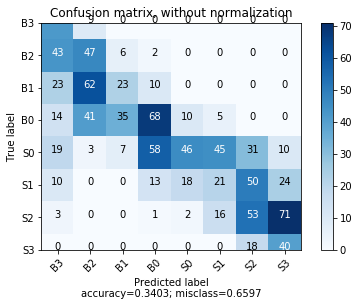

In [106]:
predict(m, c, s, i)